In [696]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os
import shutil
from Cyclist_env_RDA_2nano import cyclist_env
from time import time
from scipy.fft import fft, ifft
from scipy.linalg import dft

import torch
import pandas as pd
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment
from scipy.ndimage import maximum_filter
from scipy.optimize import minimize_scalar

In [697]:
def Radar_setting():
    ###### symbol time & carrier frequency ######
    T_symbol = 5.575 * 1e-6              # symbol duration, with CP time
    T_OFDM = 5.2125 * 1e-6
    f_carrier = 28 * 1e+9
    Tc = 2.545*1e-9                      # sampling time

    ###### tx/rx ######
    N_ant = 16                       # the number of antennas
    # BW = 1.966080e+9                      # chirp bandwidth
    BW = 400*1e+6                    # chirp bandwidth
    BW_sub = BW/N_ant
    N_sample = int(np.floor(T_symbol/Tc))           # the number of samples of single chirp
    rx_sample = 813 + N_sample

    ###### Radar setting ######

    mu = BW_sub/T_symbol * 0.98
    l_speed = 299792458

    lam = l_speed/f_carrier
    env = cyclist_env(f_carrier, N_ant, BW, BW_sub, N_sample, rx_sample, Tc, mu, l_speed)
    return T_symbol,f_carrier,Tc,N_ant,BW,BW_sub,N_sample,rx_sample, mu, l_speed, lam, env

In [698]:
def Sim_Setting():
    # シミュレーション設定
    p_bs = np.array([250, -18, 50])                         #基地局の位置

    # 各車両の数
    num_cy = 1
    num_ve = 1
    num_rp = 0

    
    # シミュレーション範囲の設定
    start_cy_idx = 150
    start_ve_idx = 100
    end_cy_idx = 240
    end_ve_idx =250

    #元のシミュレーション設定
    #start_cy_idx = 75
    #start_ve_idx = 25

    #end_cy_idx = 135
    #end_ve_idx = 125
    

    cy_interval = 3
    ve_interval = 5

    cy_v_value = 6
    ve_v_value = 10
    
    return p_bs, num_cy, num_ve, num_rp, start_cy_idx, start_ve_idx, end_cy_idx, end_ve_idx, cy_v_value, ve_v_value, cy_interval, ve_interval

In [699]:
def syntax_check(num, idx, y_value, velocity_value, x_pos):
    idx_list = np.zeros(num, dtype=np.int32)
    position, velocity = np.zeros((num, 3)), np.zeros((num, 3))
    i=0
    s = set()
    while i < num:
        # 初期値における距離間隔を保証するための処理
        if idx+10 in s or idx-10 in s or idx in s: continue
        for j in range(-20,20): s.add(idx+j)
        
        idx_list[i] = idx
        position[i] = np.array([x_pos[idx], y_value, 1])
        # v_cy[i] = np.array([np.random.rand(1)[0]*5.56, 0, 0])
        velocity[i] = np.array([velocity_value, 0, 0])
        
        i+=1
    return idx_list, position, velocity

In [700]:
def get_snapshot_data(cy_idx_target, ve_idx_target,x_pos, p_bs, tx, cy_v_value, ve_v_value, num_cy, num_ve, num_rp, sym_duration, N_trans,Tc, env):
    # Cyclistについて
    cy_idx = np.zeros(num_cy, dtype=np.int32)
    p_cy, v_cy = np.zeros((num_cy, 3)), np.zeros((num_cy, 3))
    # 範囲外アクセスを防ぐための処理
    cy_idx, p_cy, v_cy = syntax_check(num_cy, cy_idx_target, 15, cy_v_value, x_pos)
    n_cy = len(p_cy)
    
    # Vehicleについて
    ve_idx = np.zeros(num_ve, dtype=np.int32)
    p_ve, v_ve = np.zeros((num_ve, 3)), np.zeros((num_ve, 3))
    # 範囲外アクセスを防ぐための処理
    ve_idx, p_ve, v_ve = syntax_check(num_ve, ve_idx_target, 7.5, ve_v_value, x_pos)
    n_ve = len(p_ve)

    # ramppostについて
    p_rp, v_rp = np.zeros((num_rp, 3)), np.zeros((num_rp, 3))
    n_rp = len(p_rp)
    
    # csvファイルの読み込み
    cy_idx += 1
    ve_idx += 1

    P_rx_cy, tstemp_rx_cy, phase_cy, P_rx_ve, tstemp_rx_ve, phase_ve, P_rx_rp, tstemp_rx_rp, phase_rp = [], [], [], [], [], [], [], [], []
    # 3番目のデータから読み込み開始（最初の数個はノイズのみのため）
    for i in range(len(cy_idx)):
        df = pd.read_csv("./ped/2.545nano/far/complex-impulse-response-Run{:04d}-Sensor_0_Tx_0_to_Rx_0.csv".format(cy_idx[i]))
        tstemp_rx_cy.append(np.round((df["Time (s)"]/Tc)).values[3:])
        P_rx_cy.append(df["| Total Complex Impulse Response total | (W)"].values[3:])
        phase_cy.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[3:])
    for i in range(len(ve_idx)):
        df = pd.read_csv("./vehicle/2.545nano/far/complex-impulse-response-Run{:04d}-Sensor_0_Tx_0_to_Rx_0.csv".format(ve_idx[i]))
        tstemp_rx_ve.append(np.round((df["Time (s)"].values[3:]/Tc)))
        P_rx_ve.append(df["| Total Complex Impulse Response total | (W)"].values[3:])
        phase_ve.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[3:])
    # 2.545のほうを使う！
    for i in range(2,3):
        df = pd.read_csv("./Ramposts/2.545nano/"+str(i)+"/complex-impulse-response-Run0001-Sensor_0_Tx_0_to_Rx_0.csv")
        tstemp_rx_rp.append(np.round((df["Time (s)"].values[5:]/Tc)))
        P_rx_rp.append(df["| Total Complex Impulse Response total | (W)"].values[5:])
        phase_rp.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[5:])
    phys_quantities = env.phys_quantities(p_bs, p_cy, v_cy, n_cy, p_ve, v_ve, n_ve, p_rp, v_rp, n_rp)
    #print(phys_quantities["relative_velocity"]["cyclists"])
    real_cy_coordinates = []
    real_vel_coordinates = []
    real_rp_coordinates = []

    for i in range(len(p_cy)):
        real_cy_coordinates.append(np.array([p_cy[i][0], p_cy[i][1]]))
    for i in range(len(p_ve)):
        real_vel_coordinates.append(np.array([p_ve[i][0], p_ve[i][1]]))
    for i in range(len(p_rp)):
        real_rp_coordinates.append(np.array([p_rp[i][0], p_rp[i][1]]))
    
        
    ######### We need some functions here. it is like this. read the csv. this outputs the time stemp and corresponding rx value.
    # P_rx_cy_dB = -114
    #P_rx_cy_dB = -111
    #P_rx_ve_dB = -114
    #P_rx_cy_dB = 0
    #P_rx_ve_dB = 0
    
    P_N_dB = -87.98

    """
    # =================================================================
    # 【実験用追加コード】自転車の信号強度ドーピング
    # =================================================================
    # 目的: 強度差が原因であることを証明するため、自転車の信号を人工的に強める
    # 設定: +15dB (約31.6倍) して、車(-7.8dB)と自転車(-25dB)の差を埋める
    
    target_gain_dB = 15.0  # ここで増幅量を調整 (12~20dB推奨)
    gain_linear = 10 ** (target_gain_dB / 10.0) # dBを倍率に変換
    
    print(f"\n[Experimental] Injecting +{target_gain_dB}dB gain to Cyclist signal...")
    
    # P_rx_cy はリスト形式 ([array(..), array(..)]) なのでループで処理
    for i in range(len(P_rx_cy)):
        original_power = 10 * np.log10(np.mean(P_rx_cy[i]) + 1e-20) # 元の平均強度(参考)
        
        # パワー(W)を定数倍する
        P_rx_cy[i] = P_rx_cy[i] * gain_linear
        
        new_power = 10 * np.log10(np.mean(P_rx_cy[i]) + 1e-20) # 後の平均強度(参考)
        print(f"  -> Cyclist {i}: {original_power:.1f}dB => {new_power:.1f}dB")

    # =================================================================
    """

    """
    # =================================================================
    # 【実験用追加コード】自動車の信号強度ドーピング
    # =================================================================
    # 目的: 強度差が原因であることを証明するため、自動車の信号を人工的に強める
    # 設定: -15dB (約31.6倍) して、車(-7.8dB)と自転車(-25dB)の差を埋める
    
    target_gain_dB = -15.0  # ここで増幅量を調整 (12~20dB推奨)
    gain_linear = 10 ** (target_gain_dB / 10.0) # dBを倍率に変換
    
    print(f"\n[Experimental] Injecting {target_gain_dB}dB gain to Vehicle signal...")
    
    # P_rx_ve はリスト形式 ([array(..), array(..)]) なのでループで処理
    for i in range(len(P_rx_ve)):
        original_power = 10 * np.log10(np.mean(P_rx_ve[i]) + 1e-20) # 元の平均強度(参考)
        
        # パワー(W)を定数倍する
        P_rx_ve[i] = P_rx_ve[i] * gain_linear
        
        new_power = 10 * np.log10(np.mean(P_rx_ve[i]) + 1e-20) # 後の平均強度(参考)
        print(f"  -> Vehicle {i}: {original_power:.1f}dB => {new_power:.1f}dB")

    # =================================================================
    """
    Y = env.rx_multiple(tx, P_rx_cy, tstemp_rx_cy, phase_cy, P_rx_ve, tstemp_rx_ve, phase_ve, P_rx_rp, tstemp_rx_rp, phase_rp, P_N_dB, sym_duration, N_trans)
    
    return Y, phys_quantities, real_cy_coordinates, real_vel_coordinates, real_rp_coordinates

In [701]:
def get_snapshot_data_with_gain(cy_idx_target, ve_idx_target, x_pos, p_bs, tx, 
                                cy_v_value, ve_v_value, num_cy, num_ve, num_rp, 
                                sym_duration, N_trans, Tc, env, 
                                cyclist_gain_dB=0.0):
    """
    cyclist_gain_dB: 自転車の信号強度に加えるゲイン [dB]。
                     正の値なら増幅、負の値なら減衰。
    """
    # --- 既存の処理 (syntax_check 等) ---
    cy_idx = np.zeros(num_cy, dtype=np.int32)
    p_cy, v_cy = np.zeros((num_cy, 3)), np.zeros((num_cy, 3))
    cy_idx, p_cy, v_cy = syntax_check(num_cy, cy_idx_target, 15, cy_v_value, x_pos)
    
    ve_idx = np.zeros(num_ve, dtype=np.int32)
    p_ve, v_ve = np.zeros((num_ve, 3)), np.zeros((num_ve, 3))
    ve_idx, p_ve, v_ve = syntax_check(num_ve, ve_idx_target, 7.5, ve_v_value, x_pos)

    p_rp, v_rp = np.zeros((num_rp, 3)), np.zeros((num_rp, 3))
    
    cy_idx += 1
    ve_idx += 1

    P_rx_cy, tstemp_rx_cy, phase_cy = [], [], []
    P_rx_ve, tstemp_rx_ve, phase_ve = [], [], []
    P_rx_rp, tstemp_rx_rp, phase_rp = [], [], []

    # CSV読み込み
    for i in range(len(cy_idx)):
        # パスは環境に合わせて適宜修正してください
        df = pd.read_csv("./ped/2.545nano/far/complex-impulse-response-Run{:04d}-Sensor_0_Tx_0_to_Rx_0.csv".format(cy_idx[i]))
        tstemp_rx_cy.append(np.round((df["Time (s)"]/Tc)).values[3:])
        P_rx_cy.append(df["| Total Complex Impulse Response total | (W)"].values[3:])
        phase_cy.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[3:])
        
    for i in range(len(ve_idx)):
        df = pd.read_csv("./vehicle/2.545nano/far/complex-impulse-response-Run{:04d}-Sensor_0_Tx_0_to_Rx_0.csv".format(ve_idx[i]))
        tstemp_rx_ve.append(np.round((df["Time (s)"].values[3:]/Tc)))
        P_rx_ve.append(df["| Total Complex Impulse Response total | (W)"].values[3:])
        phase_ve.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[3:])

    # Ramposts (必要に応じて)
    for i in range(2,3):
        # 簡易的な処理として読み込みますが、今回の実験に影響なければそのままで
        try:
            df = pd.read_csv("./Ramposts/2.545nano/"+str(i)+"/complex-impulse-response-Run0001-Sensor_0_Tx_0_to_Rx_0.csv")
            tstemp_rx_rp.append(np.round((df["Time (s)"].values[5:]/Tc)))
            P_rx_rp.append(df["| Total Complex Impulse Response total | (W)"].values[5:])
            phase_rp.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[5:])
        except:
            pass # ファイルがない場合などはスキップ

    phys_quantities = env.phys_quantities(p_bs, p_cy, v_cy, len(p_cy), p_ve, v_ve, len(p_ve), p_rp, v_rp, len(p_rp))
    
    # === 信号強度操作と差分計算 ===
    # ゲインをリニア倍率に変換
    gain_linear = 10 ** (cyclist_gain_dB / 10.0)
    
    # 自転車の信号強度を変更
    avg_power_cy = 0
    for i in range(len(P_rx_cy)):
        P_rx_cy[i] = P_rx_cy[i] * gain_linear
        if len(P_rx_cy[i]) > 0:
            avg_power_cy += np.mean(P_rx_cy[i])
    if len(P_rx_cy) > 0: avg_power_cy /= len(P_rx_cy)
            
    # 自動車の信号強度（参照用）
    avg_power_ve = 0
    for i in range(len(P_rx_ve)):
        if len(P_rx_ve[i]) > 0:
            avg_power_ve += np.mean(P_rx_ve[i])
    if len(P_rx_ve) > 0: avg_power_ve /= len(P_rx_ve)

    # 強度差 (Vehicle - Cyclist) [dB]
    # 車の方が大きいと正の値
    power_ve_db = 10 * np.log10(avg_power_ve + 1e-20)
    power_cy_db = 10 * np.log10(avg_power_cy + 1e-20)
    power_diff_dB = power_ve_db - power_cy_db
    
    P_N_dB = -87.98
    
    # 信号生成
    Y = env.rx_multiple(tx, P_rx_cy, tstemp_rx_cy, phase_cy, P_rx_ve, tstemp_rx_ve, phase_ve, P_rx_rp, tstemp_rx_rp, phase_rp, P_N_dB, sym_duration, N_trans)
    
    # 座標などの取得
    real_cy_coordinates = []
    real_vel_coordinates = []
    real_rp_coordinates = []
    for i in range(len(p_cy)): real_cy_coordinates.append(np.array([p_cy[i][0], p_cy[i][1]]))
    for i in range(len(p_ve)): real_vel_coordinates.append(np.array([p_ve[i][0], p_ve[i][1]]))
    
    return Y, phys_quantities, real_cy_coordinates, real_vel_coordinates, power_diff_dB

# 2. 閾値調査用メイン関数
def investigate_separation_threshold(target_cy_idx, target_ve_idx, env):
    # --- 設定パラメータ (Sim_Setting等から取得または固定) ---
    T_symbol,f_carrier,Tc,N_ant,BW,BW_sub,N_sample,rx_sample, mu, l_speed, lam, _ = Radar_setting()
    N_trans = 89
    tx = env.tx()
    p_bs = np.array([250, -18, 50])
    
    # 速度等の固定値 (必要に応じて変更してください)
    cy_v_value = 0 # 例
    ve_v_value = 0 # 例
    num_cy, num_ve, num_rp = 1, 1, 0
    x_pos = [-40.0] # ダミーのx_pos (syntax_check用)

    # --- 調査するゲインの範囲 ---
    # -20dB (自転車を弱める) から +40dB (自転車を強める) まで走査
    gain_range = np.arange(-20, 41, 2) 
    
    results_diff = []
    results_count = []
    results_angles = []

    print(f"=== Separation Threshold Investigation ===")
    print(f"Target Indices -> Cyclist: {target_cy_idx}, Vehicle: {target_ve_idx}")
    print(f"Checking gains from {gain_range[0]} dB to {gain_range[-1]} dB...\n")

    for gain in gain_range:
        # データ生成
        Y, phys, cy_coord, ve_coord, power_diff = get_snapshot_data_with_gain(
            target_cy_idx, target_ve_idx, x_pos, p_bs, tx, 
            cy_v_value, ve_v_value, num_cy, num_ve, num_rp, 
            T_symbol, N_trans, Tc, env, 
            cyclist_gain_dB=gain
        )
        
        # MUSIC法実行
        # num_signals は自転車+自動車で 2 と想定
        est_ang = MUSIC_method_improved(Y, N_ant, num_signals=2)
        
        # 結果保存
        num_detected = len(est_ang)
        results_diff.append(power_diff)
        results_count.append(num_detected)
        results_angles.append(est_ang)
        
        # ログ出力 (適宜コメントアウト)
        # print(f"Gain: {gain:+3.0f}dB | PowerDiff(Ve-Cy): {power_diff:5.1f}dB | Detected: {num_detected} | Angles: {[round(a,2) for a in est_ang]}")

    # --- プロット ---
    plt.figure(figsize=(10, 6))
    plt.plot(results_diff, results_count, 'o-', linewidth=2)
    plt.axhline(y=2, color='r', linestyle='--', alpha=0.5, label='Target Count (2)')
    
    plt.title(f"Separation Performance vs Signal Power Difference\n(Cyclist Idx: {target_cy_idx}, Vehicle Idx: {target_ve_idx})")
    plt.xlabel("Power Difference (Vehicle - Cyclist) [dB]")
    plt.ylabel("Number of Detected Objects")
    plt.grid(True)
    plt.legend()
    
    # x軸を反転させるかはお好みで（右に行くほど車が強い＝自転車が弱い）
    # plt.gca().invert_xaxis() 
    
    plt.show()
    
    return pd.DataFrame({
        "Gain_Added_dB": gain_range,
        "Power_Diff_Ve_minus_Cy_dB": results_diff,
        "Detected_Count": results_count,
        "Estimated_Angles": results_angles
    })

In [702]:
def derectory_deletor(directory_path):
    try:
        # ディレクトリ内のすべてのエントリ（ファイルとフォルダ）を取得
        for entry in os.listdir(directory_path):
            full_path = os.path.join(directory_path, entry)

            # ファイルかどうかをチェック
            if os.path.isfile(full_path):
                # ファイルを削除
                os.remove(full_path)
            
            # サブディレクトリの場合はスキップ
            elif os.path.isdir(full_path):
                print(f"⏭️ サブディレクトリはスキップしました: {full_path}")
                # サブディレクトリ内のファイルも削除したい場合は、
                # ここで再帰的にこの関数を呼び出すなどの処理が必要です
                # (例: delete_all_files_in_directory(full_path))
    except FileNotFoundError:
        print(f"エラー: ディレクトリが見つかりません - {directory_path}")
    except Exception as e:
        print(f"ファイル削除中にエラーが発生しました: {e}")
    return

In [724]:
def MUSIC_method_improved(Y, N_ant, num_signals):
    '''
    修正前
    Y_music = np.mean(Y, axis=0)
    R_yy = Y_music@np.conjugate(np.transpose(Y_music))
    '''
    # 修正後: 
    # チャープ軸(0)とサンプル軸(2)の両方を「スナップショット」として扱います。
    # (N_trans, N_ant, N_sample) -> (N_ant, N_trans * N_sample) に変形
    # これにより、N_trans(チャープ数)が増えるほど、スナップショット数が増え、
    # 共分散行列 R_yy の推定精度が向上します。
    
    N_trans, N_ant_data, N_sample = Y.shape
    # データを (アンテナ数 x 全サンプル数) の2次元行列に変形
    Y_music = Y.transpose(1, 0, 2).reshape(N_ant_data, -1)
    
    # 共分散行列の計算
    # (行列サイズは アンテナ数 x アンテナ数 のまま変わらないので計算負荷は軽微です)
    R_yy = (Y_music @ np.conjugate(Y_music.T)) / Y_music.shape[1]
    
    # 1.固有値分解
    eig_val, eig_vec = np.linalg.eig(R_yy)

    # 2.固有値をソートして雑音部分空間を取得
    idx = np.abs(eig_val).argsort()[::-1]
    # インデックスによって固有値と固有ベクトルの対応関係を維持しつつソート
    eig_val = eig_val[idx]
    eig_vec = eig_vec[:, idx]
    # 雑音部分空間Uを取得

    # num_signalsを固有値から推定?
    
    # デバッグ用
    num_signals = 5
    
    U = eig_vec[:, num_signals:]

    # 3.雑音部分空間とvalごとのステアリングベクトルの内積を計算
    resp = []
    argm = (np.arange(1800)-900)/100
    for val in argm:
        # ステアリングベクトルの計算
        stv = stevec(N_ant, val*np.pi/180)
        # 雑音部分空間との内積
        p = stv.T@U
        # L2ノルムの二乗を計算(pp^H)
        pp = p*np.conjugate(np.transpose(p))
        # A1は行列を1次元配列に変換するメソッド
        # respに逆数を追加
        # 分子は角度推定の上では不要なので省略している
        resp.append(1/(np.abs(pp)**2).A1)

    # 4.ピーク検出
    M = np.max(resp)
    
    # デバッグ用
    MUSIC_method_Debug(eig_val, N_ant, num_signals, resp, argm, M)
    
    est_ang = []
    # 三点比較によるピーク検出
    a, b = resp[0][0], resp[1][0]
    for i in range(1,len(argm)-1):
        c = resp[i+1][0]
        #if a < b and b > c and b > 0.2 * M:
        if a < b and b > c and b > 0.01 * M:
            est_ang.append(argm[i])
        a, b = b, c
    return est_ang

In [722]:
def MUSIC_method_Debug(eig_val, N_ant, num_signals, resp, argm, M):
    """
    MUSIC法の状態を診断するためのデバッグ関数
    """
    print("\n" + "="*30)
    print("【MUSIC法 デバッグ情報】")
    
    # --- 1. 数値情報の出力 ---
    # 固有値の絶対値（大きい順）
    eig_abs = np.abs(eig_val)


    # --- 2. グラフ描画 (重要) ---
    try:
        # --- ピークのグラフだけ表示 ---
        fig, ax = plt.subplots(figsize=(8, 5))
        resp_array = np.array(resp).flatten() # 形状を1次元に統一
        
        ax.plot(argm, resp_array, label='MUSIC Spectrum')
        ax.set_title(f'MUSIC Spectrum (N_ant={N_ant}, K={num_signals})')
        ax.set_xlabel('Angle [deg]')
        ax.set_ylabel('Spectrum Power')
        ax.set_yscale('log') # スペクトルも対数で見ると弱いピークが見つけやすい
        ax.grid(True, which="both", ls="-", alpha=0.5)
        
        # 閾値の線を引く (赤の点線)
        threshold_val = 0.2 * M
        ax.axhline(y=threshold_val, color='r', linestyle='--', label='Threshold (20%)')
        
        # もし閾値を5%に下げたらどう見えるかも参考として表示 (緑の点線)
        ax.axhline(y=0.01 * M, color='g', linestyle=':', label='Threshold (1%)')
        
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        print("-> 診断用グラフを描画しました")
        
    except Exception as e:
        print(f"-> グラフ描画中にエラーが発生しました: {e}")
        
    print("="*30 + "\n")

In [705]:
def Root_MUSIC(Y, N_ant, num_signals=None, min_magnitude=0.8): # ← min_magnitudeのデフォルト値を調整可能に
    """
    修正版: 個数制限(K)を緩和し、閾値以上の大きさを持つ根をすべて返す
    min_magnitude: 信号根とみなす最小の絶対値（低SNR対策で少し広めにとる）
    """
    # 1. 共分散行列の計算 (変更なし)
    N_trans, N_ant_data, N_sample = Y.shape
    Y_reshaped = Y.transpose(1, 0, 2).reshape(N_ant_data, -1)
    R = (Y_reshaped @ np.conjugate(Y_reshaped.T)) / Y_reshaped.shape[1]
    
    # 2. 固有値分解 & 雑音部分空間 (変更なし)
    # ここでの num_signals は「雑音部分空間を作るための次元数」として使う
    # 推定用Kとは区別するため、呼び出し側で十分な信号数（例:5）を指定しておく
    K_subspace = 5 # 雑音空間定義用にあえて固定または引数利用
    
    eig_val, eig_vec = np.linalg.eig(R)
    idx = np.abs(eig_val).argsort()[::-1]
    eig_vec = eig_vec[:, idx]
    U_n = eig_vec[:, K_subspace:] # 上位K個以外をノイズとする
    
    # 3. 多項式の係数算出 (変更なし)
    C = U_n @ U_n.conj().T
    coeffs = np.zeros(2 * N_ant - 1, dtype=np.complex128)
    for k in range(-(N_ant - 1), N_ant):
        coeffs[k + (N_ant - 1)] = np.trace(C, offset=k)
    roots = np.roots(coeffs)
    
    # --- フィルタリング処理 ---
    # 単位円の内側のみ
    roots = roots[np.abs(roots) <= 1.0 + 1e-6]
    
    # ★ここが重要: 半径が小さい（中心に近い）根はノイズとして捨てる
    # 信号強度が弱いと、信号根も内側に入り込むため、ここの値(0.8など)で調整する
    valid_roots = roots[np.abs(roots) > min_magnitude]
    
    # ソートなどの処理
    dist_from_unit_circle = np.abs(np.abs(valid_roots) - 1.0)
    idx_sorted = dist_from_unit_circle.argsort()
    selected_roots = valid_roots[idx_sorted]
    
    # ==========================================
    # ★ここにデバッグ用コードを追加
    # ==========================================
    print(f"Total roots inside unit circle: {len(roots)}")
    print(f"Selected roots (magnitude > {min_magnitude}): {len(selected_roots)}")
    
    # グラフ描画（毎回出ると大変なので、必要に応じてコメントアウト）
    plot_roots_on_unit_circle(roots, selected_roots)
    # ==========================================

    # 5. 角度への変換
    angles_rad = np.arcsin(np.angle(selected_roots) / np.pi)
    angles_deg = np.degrees(angles_rad)
    angles_deg.sort()
    
    return angles_deg

In [706]:
def plot_roots_on_unit_circle(roots, selected_roots):
    plt.figure(figsize=(6,6))
    
    # 単位円
    t = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(t), np.sin(t), 'k--', alpha=0.5)
    
    # 全ての根
    plt.scatter(np.real(roots), np.imag(roots), marker='x', color='gray', label='All Roots')
    
    # 選択された根
    plt.scatter(np.real(selected_roots), np.imag(selected_roots), marker='o', color='red', label='Selected')
    
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    plt.grid()
    plt.legend()
    plt.title("Root Constellation")
    plt.show()

In [707]:
def get_spatial_power_at_angle(Y, angle_deg, N_ant):
    """
    指定した角度における空間電力を計算する関数
    (Beamformer法によるパワー推定)
    """
    # 共分散行列 R の計算
    N_trans, N_ant_data, N_sample = Y.shape
    Y_reshaped = Y.transpose(1, 0, 2).reshape(N_ant_data, -1)
    R = (Y_reshaped @ np.conjugate(Y_reshaped.T)) / Y_reshaped.shape[1]
    
    # ステアリングベクトル
    theta_rad = angle_deg * np.pi / 180.0
    a = stevec(N_ant, theta_rad)
    
    # 電力 P = a^H * R * a
    # (実際の信号強度に比例する値が得られます)
    power = np.abs(a.H @ R @ a)[0,0]
    
    return power

In [708]:
def FFT(N_trans, N_ant, rx_sample, Y, tx, N_sample, est_ang, sym_duration, lam, Tc, env):
    # ドップラー処理
    Dopp_dft = dft(N_trans)/np.sqrt(N_trans)
    Y_dft = np.zeros((N_trans, N_ant, rx_sample), dtype=np.complex128)
    for i in range(N_ant):
        Y_dft[:,i,:] = Dopp_dft@Y[:,i,:]

    final_objects_all = []
    rd_maps = []

    P_range = np.arange(190)+620

    # FFTによる位置推定処理
    tx_arr = np.array(tx) 
    n_fft = 2**(int(rx_sample + N_sample).bit_length())
    
    # 窓関数を掛けずにFFTする
    TX_F_all = fft(tx_arr, n=n_fft, axis=1) 
    Y_F_all = fft(Y_dft, n=n_fft, axis=2)

    for i in range(len(est_ang)):
        current_angle = est_ang[i]
        ang_rad = current_angle * np.pi / 180
        
        # ステアリングベクトル (N_ant, 1)
        s_vec = np.array(stevec(N_ant, ang_rad))
        
        # --- 周波数領域でのビームフォーミング ---
        
        # 受信信号の合成: Y_combined = sum(Y * s)
        # s_vec を (1, N_ant, 1) に変形して放送
        # Y_F_all: (N_trans, N_ant, n_fft)
        # 重み付け和をとってアンテナ次元を潰す -> (N_trans, n_fft)
        # 修正前
        w_vec = np.conjugate(s_vec).reshape(1, N_ant, 1)
        Y_F_combined = np.sum(Y_F_all * w_vec, axis=1)
        # 修正後
        w_vec = s_vec.reshape(1, N_ant, 1) 
        Y_F_combined = np.sum(Y_F_all * w_vec, axis=1)

        # 送信信号(レプリカ)の合成: X_combined = sum(X * s*)
        # 元の数式 g = s* s^H X より、Xにかかる重みは s^H (つまり sの共役)
        # TX_F_all: (N_ant, n_fft)
        s_vec_conj_reshape = np.conjugate(s_vec).reshape(N_ant, 1)
        TX_F_combined = np.sum(TX_F_all * s_vec_conj_reshape, axis=0) # -> (n_fft,)

        # --- 相関演算 (Correlation) ---
        # Correlation = IFFT( FFT(Y) * conj(FFT(X)) )
        # Broadcasting: (N_trans, n_fft) * (n_fft,)
        CORR_f = Y_F_combined * np.conjugate(TX_F_combined)
        
        # 時間領域に戻す
        corr_time = ifft(CORR_f, axis=1)

        # --- 必要な範囲を切り出し ---
        rdresp_single = corr_time[:, P_range]

        # --- 結果保存 ---
        rd_maps.append(rdresp_single.copy())
        rd_maps.append(i)
        
    return rd_maps

In [709]:
def CFAR(rd_maps, est_ang, N_trans, sym_duration, lam, Tc, env):
    detected_objects = []

    for k in range(0, len(rd_maps), 2):
        rdresp_single = rd_maps[k]
        angle = rd_maps[k+1]
        # 1. CFAR実行
        # radar_inの作成 (Batch, Channel, Height, Width)
        radar_in = torch.tensor(np.abs(rdresp_single)).unsqueeze(0).unsqueeze(0)
        detections_bool = ca_cfar_improved(radar_in, convert_from_db=False)

        # 2. dBマップの準備 (Thresholder用)
        radar_db = 20 * torch.log10(radar_in[0,0])

        # 3. 閾値判定 (速度方向も見てフィルタリング)
        clean_targets = extract_peaks_scipy(radar_db, detections_bool[0,0], kernel_size=5, tar_thres=-27.5)

        # 5. 結果の保存
        if len(clean_targets) > 0:
            print(f"角度 {est_ang[angle]:.2f} 度 のマップからの検出:")
            for tgt in clean_targets:
                d_idx, r_idx, power = tgt
                
                # 物理量への変換 (別途 sym_duration, lam の定義が必要)
                r_est, v_est, x_est, y_est = convert_to_physical(
                    d_idx, r_idx, N_trans, sym_duration, lam, est_ang[angle], idx_to_xy, Tc, env
                )
                #detected_objects.append([r_est, v_est, current_angle, x_est, y_est]) # v_estを追加
                # 【変更点】 power もリストに追加します (末尾に追加)
                detected_objects.append([r_est, est_ang[angle], x_est, y_est, v_est, power])
                print(f"  -> Index: ({d_idx}, {r_idx}), Power: {power:.1f}dB, Range: {r_est:.2f}m, Vel: {v_est:.2f}m/s")
        else:
            print("ターゲット不検出")
        # --- ここまで ---
    # 【追加】 ここで全角度の検出結果をまとめてクリーニングします
    #final_objects = remove_ghosts_across_angles(detected_objects)    
    final_objects = remove_ghosts_improved(detected_objects)
    return final_objects

In [710]:
def remove_ghosts_improved(all_detections, range_tol=1.0, ang_tol=0.01, vel_tol=1.0, power_ratio_thres_db=2.0, dist_xy_tol=2.0):
    """
    改良版: 物理的な重複判定とサイドローブ除去を区別して処理する関数
    
    Args:
        all_detections: [[range, angle, x, y, vel, power], ...]
        range_tol: 同一物体とみなす距離差 [m]
        ang_tol: 同一物体とみなす角度差 [deg]
        vel_tol: 同一物体とみなす速度差 [m/s]
        power_ratio_thres_db: 角度が離れている場合、このdB以上弱ければゴーストとみなす [dB]
        dist_xy_tol: XY座標上での距離許容値 [m] (物理的な近さ)
    """
    if not all_detections:
        return []

    # 1. パワーが強い順に並べ替える (index 5 = power)
    sorted_dets = sorted(all_detections, key=lambda x: x[5], reverse=True)
    
    final_unique_objects = []
    
    while sorted_dets:
        # 最も強い検出を取り出す（これが「本物」の可能性が最も高い）
        best = sorted_dets.pop(0)
        final_unique_objects.append(best)
        
        remaining = []
        for other in sorted_dets:
            # 各差分を計算
            r_diff = abs(best[0] - other[0])
            a_diff = abs(best[1] - other[1])
            v_diff = abs(best[4] - other[4])
            
            # XY座標での距離 (物理的に同じ場所か？)
            # best[2], best[3] が X, Y
            xy_dist = np.sqrt((best[2] - other[2])**2 + (best[3] - other[3])**2)
            
            # パワー差 (dB)
            p_diff = best[5] - other[5] # sorted済みなので必ず正の値

            # --- 判定ロジック ---

            # A. 「完全に同一の物体」の結合
            # 距離・角度・速度がすべて近い、またはXY座標が非常に近い場合
            is_same_target = (r_diff < range_tol and a_diff < ang_tol and v_diff < vel_tol) or (xy_dist < dist_xy_tol)
            is_same_target = (r_diff < range_tol and v_diff < vel_tol)

            # B. 「サイドローブ（ゴースト）」の判定
            # 距離と速度は同じだが、角度が違う場合。
            # ただし、パワーが「圧倒的に弱い（power_ratio_thres_db以上差がある）」場合のみゴーストとする。
            # ※ パワー差が小さいなら、それは並走している別の車両や自転車の可能性が高い。
            is_sidelobe = (r_diff < range_tol and v_diff < vel_tol) and (p_diff > power_ratio_thres_db)
            is_sidelobe = (a_diff < ang_tol) and (p_diff > power_ratio_thres_db)

            # どちらにも該当しなければ、リストに残す（次のループで採用される候補）
            if is_same_target or is_sidelobe:
                continue 
            else:
                remaining.append(other)
        
        sorted_dets = remaining

    return final_unique_objects

In [711]:
def ca_cfar_improved(x_db, n_train=(1,7), n_guard=(1,5), pfa=1e-6, convert_from_db=False):
    """
    2次元 CA-CFAR (Cell Averaging CFAR)
    x_db: (B, 1, H, W) 入力マップ (通常はdB)
    戻り値: (B, 1, H, W) のBool型テンソル (Trueが検出位置)
    """
    # 修正
    n_guard = (1,10)
    pfa = 1e-4

    if convert_from_db:
        x = 10 ** (x_db / 10.0)
    else:
        x = x_db

    B, C, H, W = x.shape
    th, tw = n_train
    gh, gw = n_guard

    # カーネル作成 (ガードセルを0、参照セルを1にする)
    kh = 2 * (th + gh) + 1
    kw = 2 * (tw + gw) + 1
    kernel = torch.ones((1, 1, kh, kw), device=x.device, dtype=x.dtype)

    #kernel[:, :, th-gh:th+gh+1, tw-gw:tw+gw+1] = 0
    # 修正案
    kernel[:, :, th : th + 2*gh + 1, tw : tw + 2*gw + 1] = 0

    N_train = kernel.sum().item()
    
    # 閾値係数 alpha の計算
    alpha = N_train * (pfa ** (-1.0 / N_train) - 1.0)

    # 修正案
    # ドップラー方向(H)は「circular」(循環)、レンジ方向(W)は「replicate」(端の値を複製)したい場合
    # PyTorchのF.padは一度に1つのモードしか指定できないため、2段階で適用します

    # 1. レンジ方向（左右）のパディング（非循環）
    pad_w = kw // 2
    x_pad_w = F.pad(x, (pad_w, pad_w, 0, 0), mode="replicate") # または "constant"

    # 2. ドップラー方向（上下）のパディング（循環：上端と下端をつなげる）
    pad_h = kh // 2
    x_pad = F.pad(x_pad_w, (0, 0, pad_h, pad_h), mode="circular")
    
    train_sum = F.conv2d(x_pad, kernel)
    noise_est = train_sum / N_train

    threshold_map = alpha * noise_est
    detections = x > threshold_map
    
    return detections

In [712]:
def extract_peaks_scipy(radar_db, detections_bool, kernel_size=5, tar_thres=-25):
    """
    SciPyを用いた可読性の高いNMS（局所最大値検出）。
    既存の thresholder_improved と cleansing_improved を代替します。
    
    Args:
        radar_db (Tensor or ndarray): dB単位のRDマップ
        detections_bool (Tensor or ndarray): CFARの検出結果マスク
        kernel_size (int): 近傍とみなす範囲（奇数推奨, 例: 5なら5x5マス）
        tar_thres (float): パワーの閾値
        
    Returns:
        list: [[dop_idx, rng_idx, power], ...] 
        (後段の処理との互換性を維持したリスト形式)
    """
    # 1. データ型をNumPyに統一 (Tensorが来ても対応)
    if hasattr(radar_db, 'cpu'):
        img = radar_db.cpu().numpy()
    else:
        img = radar_db
        
    if hasattr(detections_bool, 'cpu'):
        mask = detections_bool.cpu().numpy()
    else:
        mask = detections_bool

    # 2. Maximum Filter で「近傍の最大値」を計算
    # これが「その範囲内で一番強い値」のマップになります
    local_max = maximum_filter(img, size=kernel_size, mode='constant', cval=-999)

    # 3. ピークの特定 (Boolean Indexing)
    # 条件A: CFARで検出されている
    # 条件B: 自分の値が近傍最大値と一致する (つまり自分がピーク)
    # 条件C: 閾値を超えている
    is_peak = mask & (img == local_max) & (img > tar_thres)

    # 4. インデックスの抽出とリスト化
    # np.argwhere で True の場所の (d_idx, r_idx) を一括取得
    peak_indices = np.argwhere(is_peak)
    
    results = []
    for d_idx, r_idx in peak_indices:
        power = float(img[d_idx, r_idx])
        results.append([d_idx, r_idx, power])
    
    # パワー順にソート (既存処理との整合性のため)
    results.sort(key=lambda x: x[2], reverse=True)
    
    return results

In [713]:
def remove_ghosts_across_angles(all_detections, range_tol=2.0, ang_tol=1.0, vel_tol=0.5):
    """
    異なる角度で検出された同一物体（サイドローブ）を統合する関数
    all_detections: [[range, vel, angle, x, y, power], ...] のリスト
    range_tol: 同一物体とみなす距離差 [m]
    vel_tol:   同一物体とみなす速度差 [m/s]
    """
    if not all_detections:
        return []

    # 1. パワーが強い順に並べ替える (一番後ろの要素がpowerと仮定)
    # x[5] が power です
    sorted_dets = sorted(all_detections, key=lambda x: x[5], reverse=True)
    
    final_unique_objects = []
    
    while sorted_dets:
        # 最も強い検出を取り出す（これが「本物」の可能性が高い）
        best = sorted_dets.pop(0)
        final_unique_objects.append(best)
        
        # 残りのリストから、「距離と角度がほぼ同じ」ものを全て削除する
        # （これらはサイドローブ＝ゴーストとみなす）
        remaining = []
        for other in sorted_dets:
            r_diff = abs(best[0] - other[0])
            a_diff = abs(best[1] - other[1])
            v_diff = abs(best[4] - other[4])
            
            # 距離と角度が近ければ、それは同じ物体のサイドローブなのでリストに残さない（削除）
            if r_diff < range_tol and a_diff < ang_tol:
                continue 
            # 距離と速度が近ければ、それは同じ物体のサイドローブなのでリストに残さない（削除）
            if r_diff < range_tol and v_diff < vel_tol:
                continue
            remaining.append(other)
        
        sorted_dets = remaining

    return final_unique_objects

In [714]:
def convert_to_physical(d_idx, r_idx, N_trans, sym_duration, lam, current_angle, idx_to_xy_func, Tc, env):
    """
    インデックスを物理的な距離(m)と速度(m/s)に変換
    """
    # 速度計算
    vel_res = lam / (2.0 * sym_duration * N_trans)
    if d_idx < N_trans / 2:
        velocity = d_idx * vel_res
    else:
        velocity = (d_idx - N_trans) * vel_res
        
    # 距離・座標計算 (既存の関数を利用)
    x, y, r = idx_to_xy_func(r_idx, current_angle, Tc, env)
    
    return r, velocity, x, y

In [715]:
def stevec(N_ant, angle):
    # 入力された角度に対するステアリングベクトルの計算
    resp = (np.arange(N_ant)-N_ant*0.5+0.5).reshape([-1,1])
    resp = np.exp(1j*resp*np.pi*np.sin(angle))
    return np.matrix(resp)

In [716]:
def idx_to_xy(range_idx, angle_deg, Tc, env):
    """
    range_idx: cy_idxs_pred の値 (例: 496)
    angle_deg: MUSIC法で推定した角度 [度] (例: est_ang[0])
    """
    p_bs = np.array([250, -18, 50])
    refangle = np.arctan(33/265)/2
    angle_offset = - 0.00005
    refangle += angle_offset
    offset = 620
    # (1) 距離の計算 [m]
    # サンプル番号 = インデックス + オフセット
    sample_idx = range_idx + offset
    # 往復時間 = サンプル番号 * Tc
    # 距離 = 往復時間 * c / 2
    R = (sample_idx * Tc * env.c) / 2

    # 三次元距離を二次元距離に変換
    height_diff = p_bs[2] - 1
    if R > height_diff:
        R_horizontal = np.sqrt(R**2 - height_diff**2)
    else:
        R_horizontal = 0

    # (2) 角度の計算 [rad]
    # 推定角度をラジアンに変換し、基準角度(refangle)を足す
    # anglecalの逆演算: cy_ang = arctan(...) - refangle なので
    # arctan(...) = cy_ang + refangle
    theta_world = np.deg2rad(angle_deg) + refangle

    # (3) XY座標の計算 [m]
    # 基地局(p_bs)からの相対位置
    # cy_denum (dx) = R * cos(theta)
    # cy_nu (dy) = R * sin(theta)
    dx = R_horizontal * np.cos(theta_world)
    dy = R_horizontal * np.sin(theta_world)

    # 世界座標（絶対座標）に変換
    # cy_denum = bs[0] - cy[0]  =>  cy[0] = bs[0] - dx
    # cy_nu    = cy[1] - bs[1]  =>  cy[1] = bs[1] + dy
    x = p_bs[0] - dx
    y = p_bs[1] + dy

    return x, y, R

In [717]:
def RD_MAP(rd_maps, frame_id, T_symbol, Tc, save_dir="./rd_maps/"):
    l_speed = 299792458 
    f_carrier = 28 * 1e+9

    lam = l_speed / f_carrier
    
    
    # ディレクトリがなければ作成
    os.makedirs(save_dir, exist_ok=True)
    
    rdresp_list = np.array(rd_maps[::2])
    #idx = np.array(rd_maps[1::2])
    
    # 距離分解能 (m)
    range_res = l_speed * Tc / 2
    
    # 横軸 (距離):
    start_sample_idx = 620
    num_range_bins = 190

    r_min = start_sample_idx * range_res
    r_max = (start_sample_idx + num_range_bins) * range_res

    v_range = lam / (2 * T_symbol)  # 最大速度範囲

    v_min_val = -v_range / 2
    v_max_val = v_range / 2
    
    i = 0

    for rd_resp in rdresp_list:
        #output = rd_resp[:100,:] + 1e-10
        #output = rd_resp + 1e-10
        #output = np.fft.fftshift(rd_resp, axes=0) + 1e-10
        # 1. ゼロ周波数を中央にシフト (縦軸方向)
        output_shifted = np.fft.fftshift(rd_resp, axes=0)
        # 2. dB変換 (対数)
        # 【重要】絶対値をとってから微小値を足す (0除算防止 & ノイズフロア確保)
        output_db = 20 * np.log10(np.abs(output_shifted) + 1e-20)

        #plt.imshow(20*np.log10(np.abs(output)), aspect='auto', interpolation='nearest',
        #     extent = [r_min, r_max, v_min_val, v_max_val], origin='lower', vmin=-30, vmax = -10)
        plt.imshow(output_db, 
                   aspect='auto', 
                   interpolation='nearest', # ドットを潰さない
                   extent=[r_min, r_max, v_min_val, v_max_val], 
                   origin='lower', 
                   vmin=-30,   # 引数で指定した値を使用
                   vmax=10,   # 引数で指定した値を使用
        )
        plt.xlabel('Range [m]')
        plt.ylabel('Velocity [m/s]') # 注: DFTのシフトをしていないため、軸の解釈に注意が必要
        plt.colorbar(label='Power [dB]')
        plt.title('Range-Doppler Map')
        plt.grid(False) # 任意
        plt.xlim(r_min,r_max)
        plt.ylim(-30,30)
        # --- 保存処理 ---
        # ファイル名を決定 (例: ./rd_maps/rd_map_12345.png)
        save_path = os.path.join(save_dir, f"rd_map_{frame_id}_for_{i}.png")
        plt.savefig(save_path)
        print(f"Saved: {save_path}")
        
        # --- クローズ処理 ---
        # show() ではなく close() することで、画面表示せずバックグラウンドで処理できます
        # 表示もしたい場合は plt.show() の前に plt.savefig() を置いてください
        plt.close()
        i += 1
    
    # 保存する
    

In [718]:
def print_true_values(num_cy, num_ve, num_rp, phys_quantities, real_cy_coordinates, real_vel_coordinates, real_rp_coordinates,
                      real_cy_coordinates_all, real_cy_ranges_all, real_cy_angles_all, real_cy_velocities_all,
                      real_ve_coordinates_all, real_ve_ranges_all, real_ve_angles_all, real_ve_velocities_all):
    if num_cy > 0:
        print("Cyclist True Position:", real_cy_coordinates)
        print("Cyclist True Range:", phys_quantities["range"]["cyclists"][0])
        print("Cyclist True Angle:", math.degrees(phys_quantities["angle"]["cyclists"][0]))
        a = math.degrees(phys_quantities["angle"]["cyclists"][0])
        real_cy_coordinates_all.append(real_cy_coordinates)
        real_cy_ranges_all.append(phys_quantities["range"]["cyclists"][0])
        real_cy_angles_all.append(phys_quantities["angle"]["cyclists"][0])
        real_cy_velocities_all.append(phys_quantities["relative_velocity"]["cyclists"][0])
    if num_ve > 0:
        print("Vehicle True Position:", real_vel_coordinates)
        print("Vehicle True Range:", phys_quantities["range"]["vehicles"][0])
        print("Vehicle True Angle:", math.degrees(phys_quantities["angle"]["vehicles"][0]))
        b= math.degrees(phys_quantities["angle"]["vehicles"][0])
        real_ve_coordinates_all.append(real_vel_coordinates)
        real_ve_ranges_all.append(phys_quantities["range"]["vehicles"][0])
        real_ve_angles_all.append(phys_quantities["angle"]["vehicles"][0])
        real_ve_velocities_all.append(phys_quantities["relative_velocity"]["vehicles"][0])
    if num_rp > 0:
        print("Ramp Post True Position:", real_rp_coordinates)
        print("Ramp Post True Range:", phys_quantities["range"]["ramposts"])
        print("Ramp Post True Angle:", math.degrees(phys_quantities["angle"]["ramposts"]))

    #print('angle difference:', np.abs(a-b))
    
    return

In [719]:
def main_simulation(i):
    # --- 保存先ディレクトリの設定 ---
    base_dir = "./montecarlo"
    rd_map_dir = os.path.join(base_dir, "rd_maps")
    
    os.makedirs(rd_map_dir, exist_ok=True)
    
    # 実行用設定
    T_symbol,f_carrier,Tc,N_ant,BW,BW_sub,N_sample,rx_sample, mu, l_speed, lam, env = Radar_setting()
    N_chirp = 89
    print("DEBUG: ", T_symbol * N_chirp)
    N_trans = N_chirp
    tx = env.tx()
    p_bs, num_cy, num_ve, num_rp, start_cy_idx, start_ve_idx, end_cy_idx, end_ve_idx, cy_v_value, ve_v_value, cy_interval, ve_interval = Sim_Setting()
    cy_idx, ve_idx = start_cy_idx, start_ve_idx
    measurement_history = []
    frame_count = 0
    
    # 画像フォルダの中身を削除 (必要に応じてコメントアウト)
    # 毎回削除すると、前の回の画像が消えます。
    derectory_deletor(rd_map_dir)
    
    T_sensing = N_chirp * T_symbol + 813 * Tc
    
    real_cy_coordinates_all, real_cy_ranges_all, real_cy_angles_all, real_cy_velocities_all, real_ve_coordinates_all, real_ve_ranges_all, real_ve_angles_all, real_ve_velocities_all = [], [], [], [], [], [], [], []

    while cy_idx <= end_cy_idx and ve_idx <= end_ve_idx:
        x_pos = list(np.arange(-450, -149)/10)
        
        Y, phys_quantities, real_cy_coordinates, real_vel_coordinates, real_rp_coordinates = get_snapshot_data(cy_idx,ve_idx,x_pos,p_bs, tx, cy_v_value, ve_v_value, num_cy, num_ve, num_rp, T_symbol, N_trans, Tc, env)
        print('使っているインデックス:', cy_idx, ve_idx)
        print_true_values(num_cy, num_ve, num_rp, phys_quantities, real_cy_coordinates, real_vel_coordinates, real_rp_coordinates,
                      real_cy_coordinates_all, real_cy_ranges_all, real_cy_angles_all, real_cy_velocities_all,
                      real_ve_coordinates_all, real_ve_ranges_all, real_ve_angles_all, real_ve_velocities_all) 
        
        est_ang = MUSIC_method_improved(Y, N_ant, num_cy + num_ve + num_rp)
        
        """
        # ==========================================================
        # 【修正版】Root-MUSIC + パワー閾値判定による検出ロジック
        # ==========================================================
        
        # 1. Root-MUSICで候補となる角度を算出
        #    ターゲット数(2)より多めのKを設定し、自転車を取りこぼさないようにする
        #    (自動車のサイドローブやノイズも候補に含まれるが、後段でフィルタリングする)
        K_search = 5  
        candidate_angles = Root_MUSIC(Y, N_ant, num_signals=K_search)
        
        est_ang = []
        
        # 2. パワー閾値の設定 [重要]
        #    実験結果に基づき、ノイズフロア(~2.8e-11)より大きく、
        #    自転車+自動車漏れ(~8.0e-11)を拾えるラインに設定
        POWER_THRESHOLD = 2.0e-11 

        # 3. 候補ごとの検証
        for ang in candidate_angles:
            # その角度における空間電力(ビームフォーマー出力)を計算
            
            p = get_spatial_power_at_angle(Y, ang, N_ant)

            # 閾値を超えている場合のみ「物体」として採用
            if p > POWER_THRESHOLD:
                est_ang.append(ang)
                # デバッグ用: 検出された角度とパワーを表示
                # print(f"  [Accept] Angle: {ang:.2f} deg, Power: {p:.2e}")
            else:
                pass
                # デバッグ用: 棄却された角度とパワーを表示
                # print(f"  [Reject] Angle: {ang:.2f} deg, Power: {p:.2e}")

        # リストをソートして出力
        est_ang.sort()
        
        # 万が一何も検出されなかった場合の処理（空リストのままでOKなら何もしない）
        if len(est_ang) == 0:
            pass
            
        # ==========================================================    
        """

        rd_maps = FFT(N_trans, N_ant, rx_sample, Y, tx, N_sample, est_ang, T_symbol, lam, Tc, env)

        detected_objects = CFAR(rd_maps, est_ang, N_trans, T_symbol, lam, Tc, env)
        
        # 画像保存 (シミュレーション番号 i をファイル名に含めると区別可能です)
        # ただし derectory_deletor が有効だと消えてしまうので注意
        RD_MAP(rd_maps, frame_count, T_symbol, Tc, save_dir=rd_map_dir)
        
        if len(detected_objects) > 0:
            for obj in detected_objects:
                measurement_history.append({
                    "Time": frame_count,
                    "Range": obj[0],
                    "Angle": obj[1],
                    "X": obj[2],
                    "Y": obj[3],
                    "Velocity": obj[4],
                    "Power": obj[5]
                })
        else:
            measurement_history.append({
                "Time": frame_count,
                "Range": np.nan,
                "Angle": np.nan,
                "X": np.nan,
                "Y": np.nan,
                "Velocity": np.nan,
                "Power": np.nan
            })

        angle_list = []
        power_list = []

        for obj in detected_objects:
            if obj[1] in angle_list:
                continue
            else:
                angle_list.append(obj[1])
            if obj[5] in power_list:
                continue
            else:
                power_list.append(obj[5])
        # --- 角度分解に成功したかを表示 ---
        if len(est_ang) > 1:
            print(len(est_ang))
            print(len(angle_list))
            if len(est_ang) == len(angle_list):
                print("成功，強度差は ->", np.abs(power_list[0]-power_list[1]))
                for obj in detected_objects:
                    print(obj)
            else:
                print("処理上で何らかの問題が発生")
        else:
            print("失敗")
        
        cy_idx += cy_interval
        ve_idx += ve_interval
        frame_count += 1
        
    # --- CSV保存 (番号付き) ---
    df_measurements = pd.DataFrame(measurement_history)
    csv_filename = os.path.join(base_dir, f"measurements_{i}.csv") # ここを修正
    df_measurements.to_csv(csv_filename, index=False)

    print("\nData generation complete.")
    print(f"Saved '{csv_filename}'.")

    real_positions = []
    csv_filename_true = os.path.join(base_dir, f"true_information_{i}.csv") # ここを修正
    
    # 【重要修正】 変数名を i から k に変更 (引数 i との衝突回避)
    for k in range(max(len(real_cy_coordinates_all), len(real_ve_coordinates_all))):
        if num_cy > 0:
            real_positions.append({
                "Time": k,
                "target_id":0,
                "X": real_cy_coordinates_all[k][0][0],
                "Y": real_cy_coordinates_all[k][0][1],
                "Range": real_cy_ranges_all[k],
                "Angle": real_cy_angles_all[k],
                "Velocity": real_cy_velocities_all[k],
            })

        if num_ve > 0:
            real_positions.append({
                "Time": k,
                "target_id":1,
                "X": real_ve_coordinates_all[k][0][0],
                "Y": real_ve_coordinates_all[k][0][1],
                "Range": real_ve_ranges_all[k],
                "Angle": real_ve_angles_all[k],
                "Velocity": real_ve_velocities_all[k]
            })
            
    df_real_positions = pd.DataFrame(real_positions)
    df_real_positions.to_csv(csv_filename_true, index=False)
    print(f"Saved true positions to '{csv_filename_true}'.")


--- Simulation Run 1/1 ---
DEBUG:  0.000496175
使っているインデックス: 150 100
Cyclist True Position: [array([-30.,  15.])]
Cyclist True Range: 286.1642884777903
Cyclist True Angle: 3.1753717668567645
Vehicle True Position: [array([-35. ,   7.5])]
Vehicle True Range: 290.30372026551777
Vehicle True Angle: 1.5665124267790125

【MUSIC法 デバッグ情報】


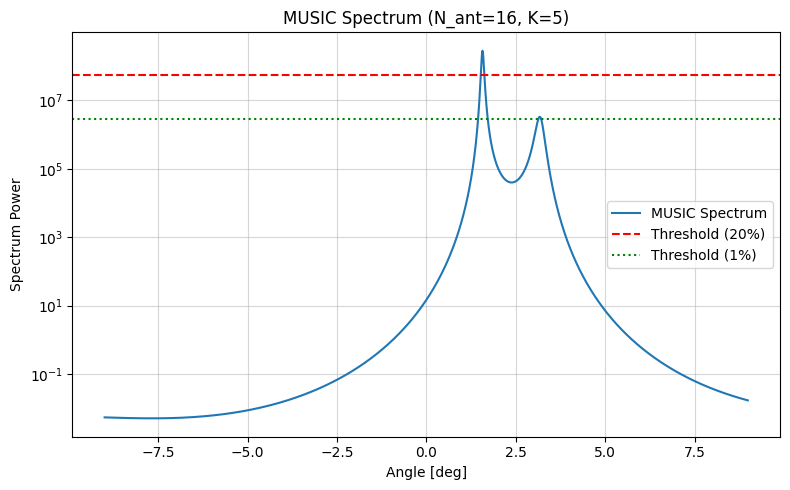

-> 診断用グラフを描画しました

角度 1.57 度 のマップからの検出:
  -> Index: (1, 136), Power: -8.2dB, Range: 288.40m, Vel: 10.79m/s
  -> Index: (1, 131), Power: -21.3dB, Range: 286.50m, Vel: 10.79m/s
角度 3.17 度 のマップからの検出:
  -> Index: (1, 136), Power: -9.5dB, Range: 288.40m, Vel: 10.79m/s
  -> Index: (1, 131), Power: -19.8dB, Range: 286.50m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_0_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_0_for_1.png
2
2
成功，強度差は -> 11.637142463615362
[np.float64(288.40334252058005), np.float64(1.57), np.float64(-33.07790286927559), np.float64(7.345391773969226), np.float64(10.789412505668365), -8.211467750162502]
[np.float64(286.49591300655504), np.float64(3.17), np.float64(-30.337372600880997), np.float64(15.013113950283135), np.float64(10.789412505668365), -19.848610213777864]
使っているインデックス: 153 105
Cyclist True Position: [array([-29.7,  15. ])]
Cyclist True Range: 285.87075751115225
Cyclist True Angle: 3.182515249184584
Vehicle True Position: [array([-34.5,   7.5])]
Vehicle True Ra

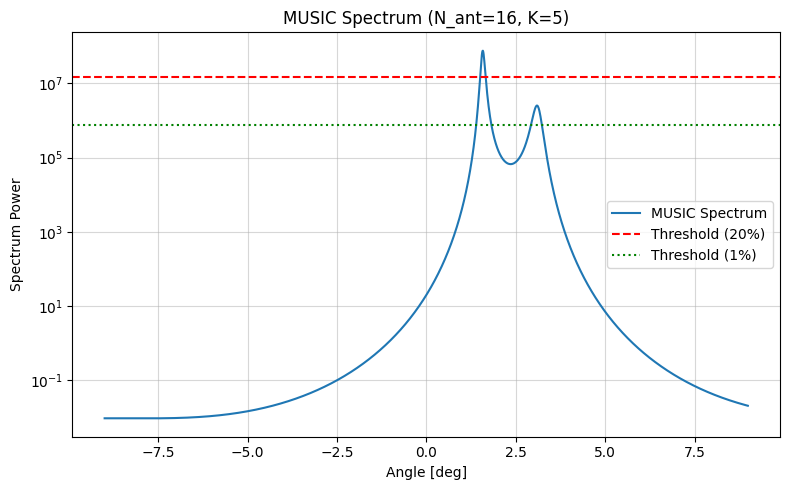

-> 診断用グラフを描画しました

角度 1.58 度 のマップからの検出:
  -> Index: (1, 135), Power: -9.6dB, Range: 288.02m, Vel: 10.79m/s
  -> Index: (1, 130), Power: -19.6dB, Range: 286.11m, Vel: 10.79m/s
角度 3.09 度 のマップからの検出:
  -> Index: (1, 135), Power: -10.4dB, Range: 288.02m, Vel: 10.79m/s
  -> Index: (1, 130), Power: -17.9dB, Range: 286.11m, Vel: 10.79m/s
  -> Index: (1, 139), Power: -27.1dB, Range: 289.55m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_1_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_1_for_1.png
2
2
成功，強度差は -> 8.253130128637256
[np.float64(288.02185661777503), np.float64(1.58), np.float64(-32.68790168243544), np.float64(7.360207647649293), np.float64(10.789412505668365), -9.603398048712176]
[np.float64(286.11442710375), np.float64(3.09), np.float64(-29.998589917240395), np.float64(14.576909633421941), np.float64(10.789412505668365), -17.856528177349432]
使っているインデックス: 156 110
Cyclist True Position: [array([-29.4,  15. ])]
Cyclist True Range: 285.57723998946415
Cyclist True Angle: 3.1896738610158

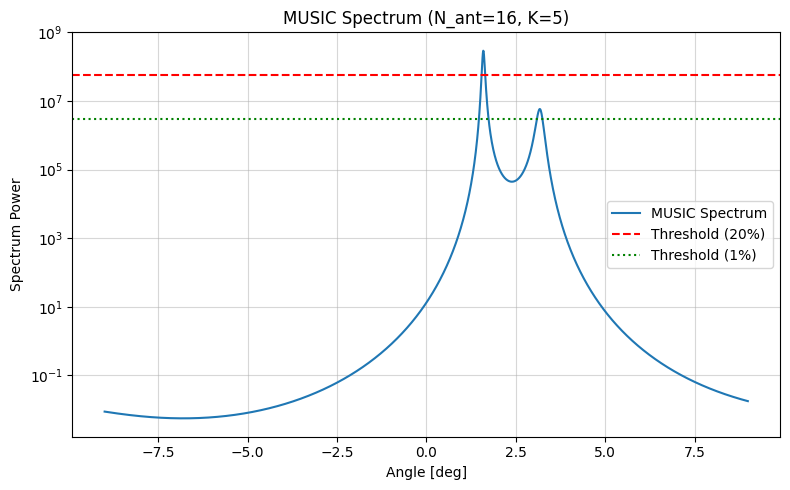

-> 診断用グラフを描画しました

角度 1.59 度 のマップからの検出:
  -> Index: (1, 133), Power: -7.7dB, Range: 287.26m, Vel: 10.79m/s
  -> Index: (1, 129), Power: -17.5dB, Range: 285.73m, Vel: 10.79m/s
角度 3.17 度 のマップからの検出:
  -> Index: (1, 133), Power: -9.2dB, Range: 287.26m, Vel: 10.79m/s
  -> Index: (1, 129), Power: -15.3dB, Range: 285.73m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_2_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_2_for_1.png
2
2
成功，強度差は -> 7.621349942259836
[np.float64(287.25888481216504), np.float64(1.59), np.float64(-31.912291004569965), np.float64(7.340226598895303), np.float64(10.789412505668365), -7.683452516953966]
[np.float64(285.73294120094505), np.float64(3.17), np.float64(-29.568274005367073), np.float64(14.922543294871979), np.float64(10.789412505668365), -15.304802459213802]
使っているインデックス: 159 115
Cyclist True Position: [array([-29.1,  15. ])]
Cyclist True Range: 285.28373595422505
Cyclist True Angle: 3.1968476502426393
Vehicle True Position: [array([-33.5,   7.5])]
Vehicle True R

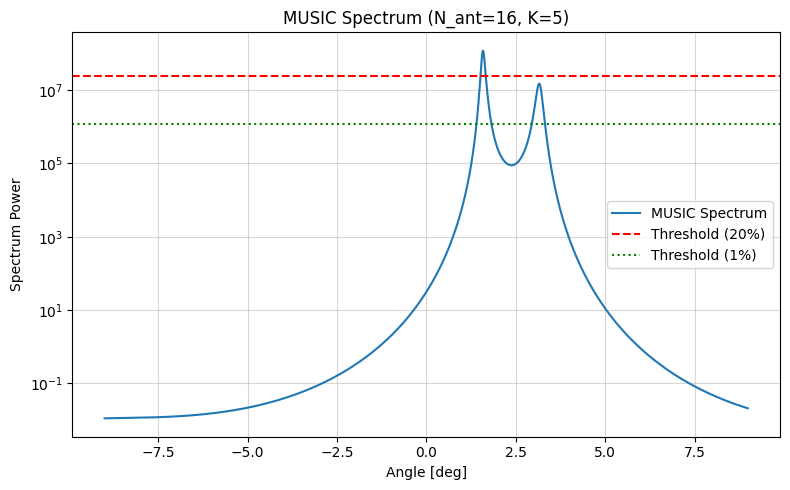

-> 診断用グラフを描画しました

角度 1.58 度 のマップからの検出:
  -> Index: (1, 132), Power: -7.5dB, Range: 286.88m, Vel: 10.79m/s
  -> Index: (1, 128), Power: -16.2dB, Range: 285.35m, Vel: 10.79m/s
  -> Index: (1, 136), Power: -25.0dB, Range: 288.40m, Vel: 10.79m/s
角度 3.15 度 のマップからの検出:
  -> Index: (1, 132), Power: -9.0dB, Range: 286.88m, Vel: 10.79m/s
  -> Index: (1, 128), Power: -13.7dB, Range: 285.35m, Vel: 10.79m/s
  -> Index: (1, 136), Power: -24.5dB, Range: 288.40m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_3_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_3_for_1.png
2
2
成功，強度差は -> 6.2166006159971685
[np.float64(286.87739890936), np.float64(1.58), np.float64(-31.531090291578835), np.float64(7.256428968382554), np.float64(10.789412505668365), -7.4713716364695335]
[np.float64(285.35145529814), np.float64(3.15), np.float64(-29.19516072222001), np.float64(14.77979972574731), np.float64(10.789412505668365), -13.687972252466702]
使っているインデックス: 162 120
Cyclist True Position: [array([-28.8,  15. ])]
Cyclist T

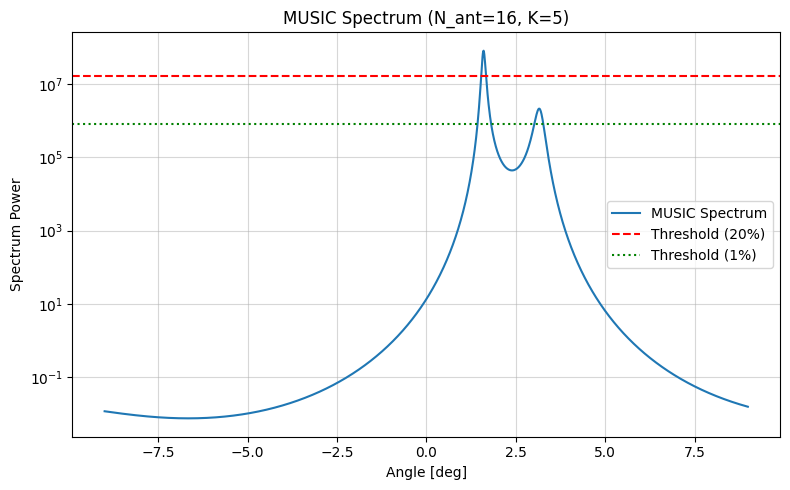

-> 診断用グラフを描画しました

角度 1.60 度 のマップからの検出:
  -> Index: (1, 131), Power: -8.9dB, Range: 286.50m, Vel: 10.79m/s
  -> Index: (1, 127), Power: -20.5dB, Range: 284.97m, Vel: 10.79m/s
  -> Index: (1, 135), Power: -25.1dB, Range: 288.02m, Vel: 10.79m/s
角度 3.15 度 のマップからの検出:
  -> Index: (1, 131), Power: -10.1dB, Range: 286.50m, Vel: 10.79m/s
  -> Index: (1, 128), Power: -18.2dB, Range: 285.35m, Vel: 10.79m/s
  -> Index: (1, 135), Power: -24.0dB, Range: 288.02m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_4_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_4_for_1.png
2
2
成功，強度差は -> 9.28701677270227
[np.float64(286.49591300655504), np.float64(1.6), np.float64(-31.136634549424343), np.float64(7.319970056913061), np.float64(10.789412505668365), -8.933754133056706]
[np.float64(285.35145529814), np.float64(3.15), np.float64(-29.19516072222001), np.float64(14.77979972574731), np.float64(10.789412505668365), -18.220770905758975]
使っているインデックス: 165 125
Cyclist True Position: [array([-28.5,  15. ])]
Cyclist T

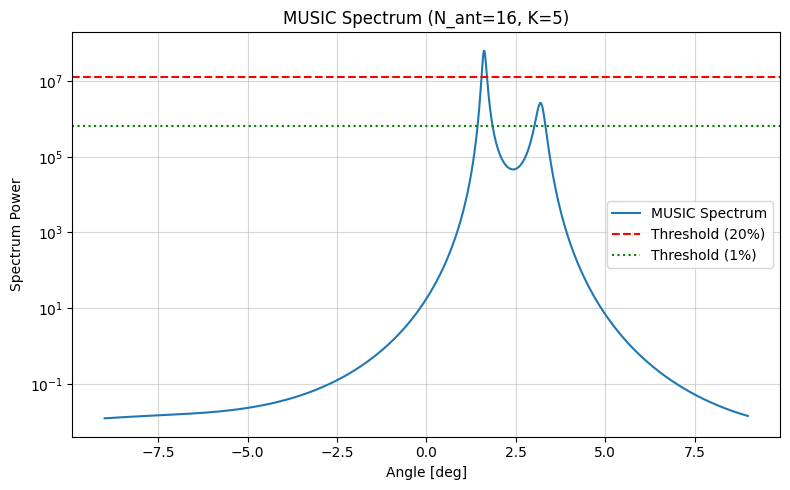

-> 診断用グラフを描画しました

角度 1.61 度 のマップからの検出:
  -> Index: (1, 129), Power: -8.8dB, Range: 285.73m, Vel: 10.79m/s
角度 3.19 度 のマップからの検出:
  -> Index: (1, 129), Power: -10.1dB, Range: 285.73m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_5_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_5_for_1.png
2
1
処理上で何らかの問題が発生
使っているインデックス: 168 130
Cyclist True Position: [array([-28.2,  15. ])]
Cyclist True Range: 284.40330518473235
Cyclist True Angle: 3.218460564241924
Vehicle True Position: [array([-32. ,   7.5])]
Vehicle True Range: 287.3590959061502
Vehicle True Angle: 1.620611566564302

【MUSIC法 デバッグ情報】


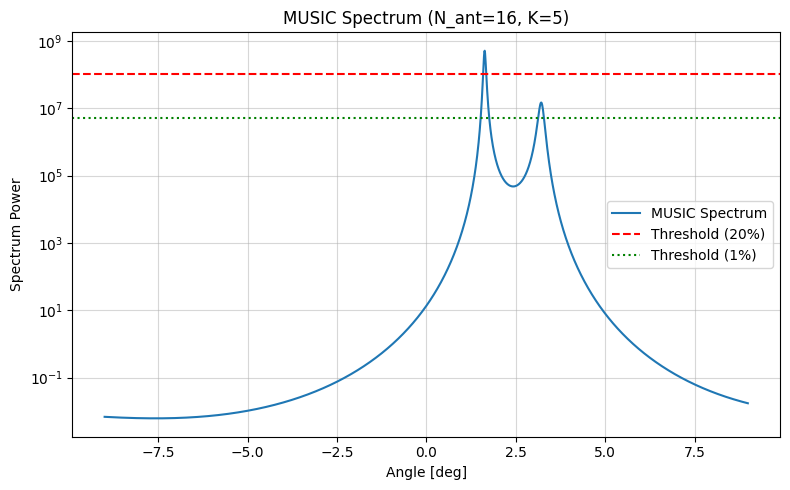

-> 診断用グラフを描画しました

角度 1.63 度 のマップからの検出:
  -> Index: (1, 128), Power: -7.9dB, Range: 285.35m, Vel: 10.79m/s
角度 3.21 度 のマップからの検出:
  -> Index: (1, 128), Power: -8.9dB, Range: 285.35m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_6_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_6_for_1.png
2
1
処理上で何らかの問題が発生
使っているインデックス: 171 135
Cyclist True Position: [array([-27.9,  15. ])]
Cyclist True Range: 284.1098555136727
Cyclist True Angle: 3.225695546013339
Vehicle True Position: [array([-31.5,   7.5])]
Vehicle True Range: 286.8684367440936
Vehicle True Angle: 1.6297392876378773

【MUSIC法 デバッグ情報】


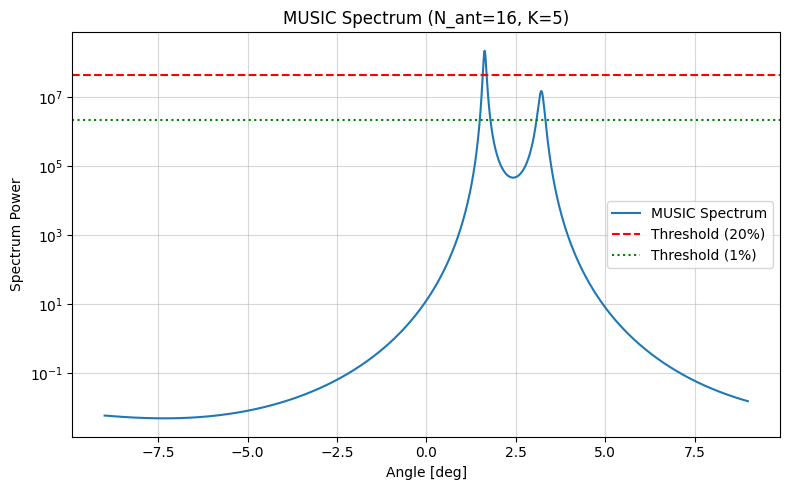

-> 診断用グラフを描画しました

角度 1.63 度 のマップからの検出:
  -> Index: (1, 127), Power: -7.5dB, Range: 284.97m, Vel: 10.79m/s
角度 3.21 度 のマップからの検出:
  -> Index: (1, 127), Power: -9.0dB, Range: 284.97m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_7_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_7_for_1.png
2
1
処理上で何らかの問題が発生
使っているインデックス: 174 140
Cyclist True Position: [array([-27.6,  15. ])]
Cyclist True Range: 283.81641953910986
Cyclist True Angle: 3.2329459476818676
Vehicle True Position: [array([-31. ,   7.5])]
Vehicle True Range: 286.3778098945517
Vehicle True Angle: 1.6388992268563658

【MUSIC法 デバッグ情報】


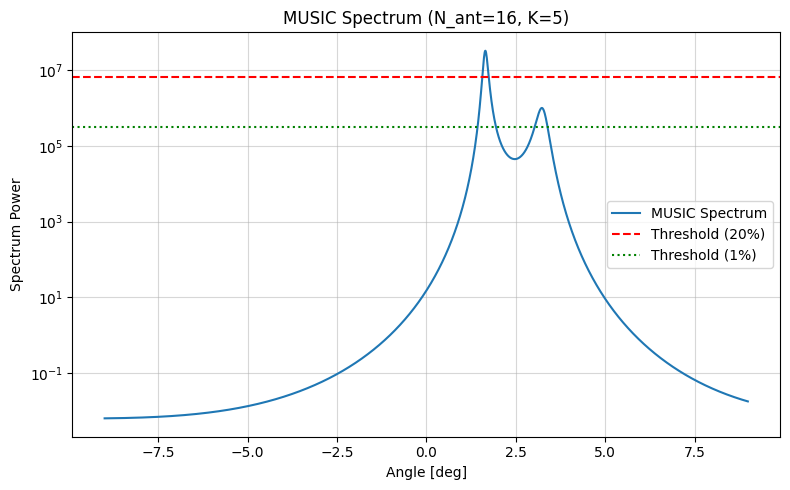

-> 診断用グラフを描画しました

角度 1.65 度 のマップからの検出:
  -> Index: (1, 126), Power: -9.3dB, Range: 284.59m, Vel: 10.79m/s
角度 3.23 度 のマップからの検出:
  -> Index: (1, 126), Power: -10.8dB, Range: 284.59m, Vel: 10.79m/s
  -> Index: (1, 131), Power: -27.1dB, Range: 286.50m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_8_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_8_for_1.png
2
2
成功，強度差は -> 17.77083522953469
[np.float64(284.58848349253003), np.float64(1.65), np.float64(-29.186238404355436), np.float64(7.389943328106227), np.float64(10.789412505668365), -9.332238585209831]
[np.float64(286.49591300655504), np.float64(3.23), np.float64(-30.30264764296271), np.float64(15.306664405260392), np.float64(10.789412505668365), -27.10307381474452]
使っているインデックス: 177 145
Cyclist True Position: [array([-27.3,  15. ])]
Cyclist True Range: 283.52299730356975
Cyclist True Angle: 3.2402118183637296
Vehicle True Position: [array([-30.5,   7.5])]
Vehicle True Range: 285.88721552388455
Vehicle True Angle: 1.6480915546313517

【MUS

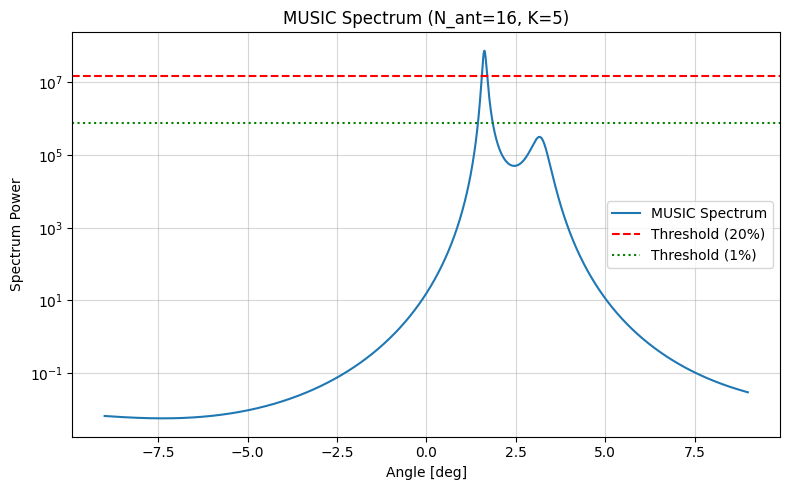

-> 診断用グラフを描画しました

角度 1.62 度 のマップからの検出:
  -> Index: (1, 124), Power: -9.3dB, Range: 283.83m, Vel: 10.79m/s
  -> Index: (1, 130), Power: -27.0dB, Range: 286.11m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_9_for_0.png
失敗
使っているインデックス: 180 150
Cyclist True Position: [array([-27.,  15.])]
Cyclist True Range: 283.22958884975276
Cyclist True Angle: 3.2474932073829588
Vehicle True Position: [array([-30. ,   7.5])]
Vehicle True Range: 285.39665379958467
Vehicle True Angle: 1.6573164425749995

【MUSIC法 デバッグ情報】


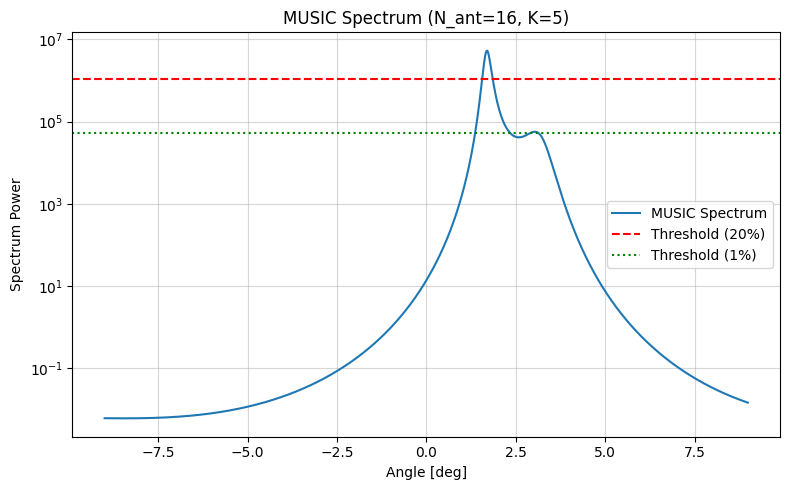

-> 診断用グラフを描画しました

角度 1.69 度 のマップからの検出:
  -> Index: (1, 123), Power: -6.7dB, Range: 283.44m, Vel: 10.79m/s
  -> Index: (1, 126), Power: -27.4dB, Range: 284.59m, Vel: 10.79m/s
角度 3.03 度 のマップからの検出:
  -> Index: (1, 123), Power: -7.3dB, Range: 283.44m, Vel: 10.79m/s
  -> Index: (1, 126), Power: -24.6dB, Range: 284.59m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_10_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_10_for_1.png
2
2
成功，強度差は -> 17.874754514674468
[np.float64(283.444025784115), np.float64(1.69), np.float64(-28.0114136176378), np.float64(7.478807880839998), np.float64(10.789412505668365), -6.730935105405108]
[np.float64(284.58848349253003), np.float64(3.03), np.float64(-28.493791013554812), np.float64(14.10628137104164), np.float64(10.789412505668365), -24.605689620079577]
使っているインデックス: 183 155
Cyclist True Position: [array([-26.7,  15. ])]
Cyclist True Range: 282.93619422053445
Cyclist True Angle: 3.2547901642725003
Vehicle True Position: [array([-29.5,   7.5])]
Vehicle True Ran

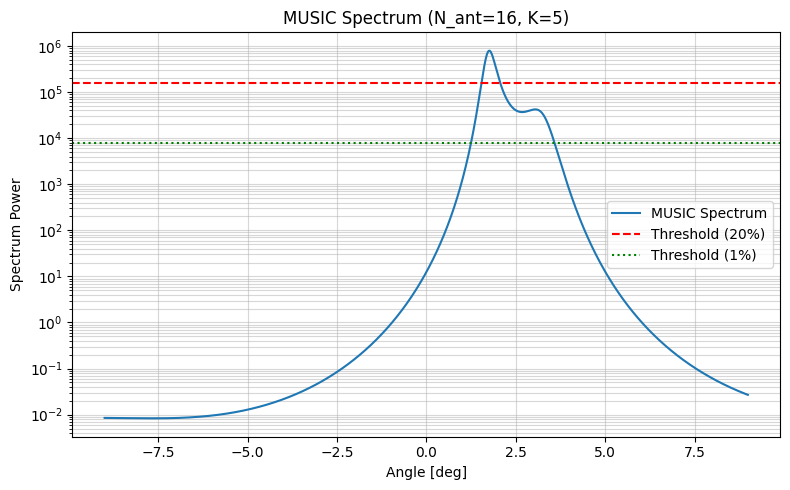

-> 診断用グラフを描画しました

角度 1.76 度 のマップからの検出:
  -> Index: (1, 122), Power: -7.5dB, Range: 283.06m, Vel: 10.79m/s
角度 3.04 度 のマップからの検出:
  -> Index: (1, 122), Power: -7.8dB, Range: 283.06m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_11_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_11_for_1.png
2
1
処理上で何らかの問題が発生
使っているインデックス: 186 160
Cyclist True Position: [array([-26.4,  15. ])]
Cyclist True Range: 282.64281345896626
Cyclist True Angle: 3.262102738775312
Vehicle True Position: [array([-29. ,   7.5])]
Vehicle True Range: 284.4156289657796
Vehicle True Angle: 1.6758645914833148

【MUSIC法 デバッグ情報】


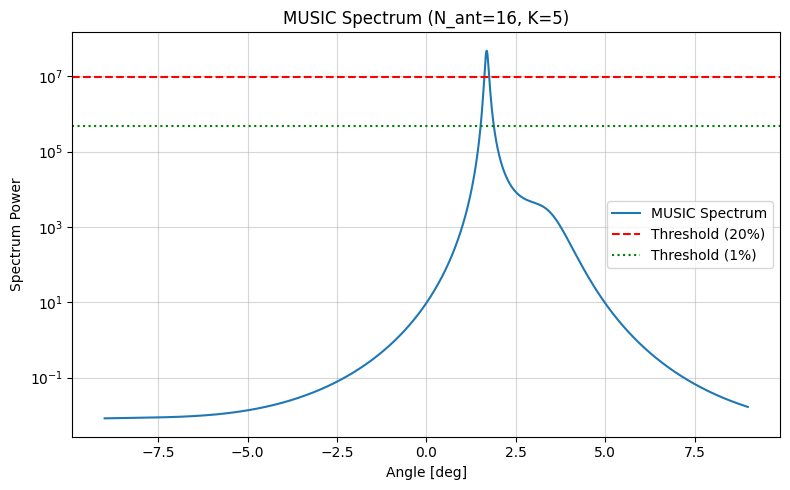

-> 診断用グラフを描画しました

角度 1.69 度 のマップからの検出:
  -> Index: (1, 120), Power: -9.7dB, Range: 282.30m, Vel: 10.79m/s
  -> Index: (1, 126), Power: -26.4dB, Range: 284.59m, Vel: 10.79m/s
  -> Index: (1, 123), Power: -27.2dB, Range: 283.44m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_12_for_0.png
失敗
使っているインデックス: 189 165
Cyclist True Position: [array([-26.1,  15. ])]
Cyclist True Range: 282.34944660827654
Cyclist True Angle: 3.2694309808454736
Vehicle True Position: [array([-28.5,   7.5])]
Vehicle True Range: 283.9251661970104
Vehicle True Angle: 1.6851882017708144

【MUSIC法 デバッグ情報】


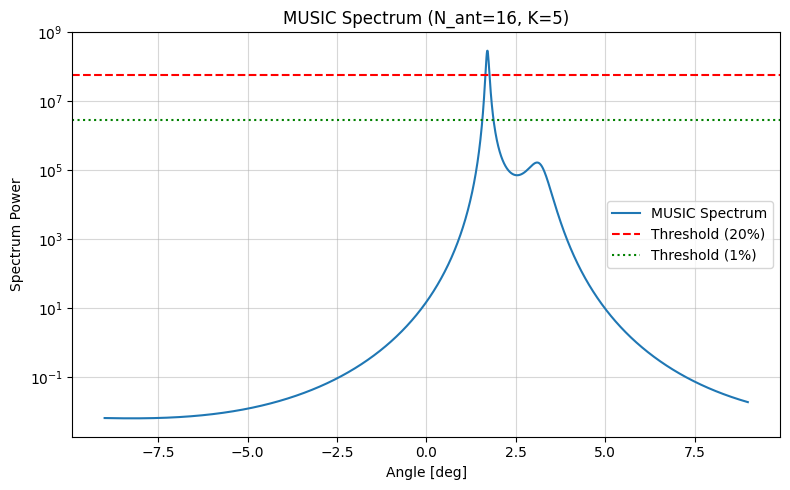

-> 診断用グラフを描画しました

角度 1.71 度 のマップからの検出:
  -> Index: (1, 119), Power: -8.5dB, Range: 281.92m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_13_for_0.png
失敗
使っているインデックス: 192 170
Cyclist True Position: [array([-25.8,  15. ])]
Cyclist True Range: 282.0560937118714
Cyclist True Angle: 3.276774940649304
Vehicle True Position: [array([-28. ,   7.5])]
Vehicle True Range: 283.4347367561005
Vehicle True Angle: 1.694545070894331

【MUSIC法 デバッグ情報】


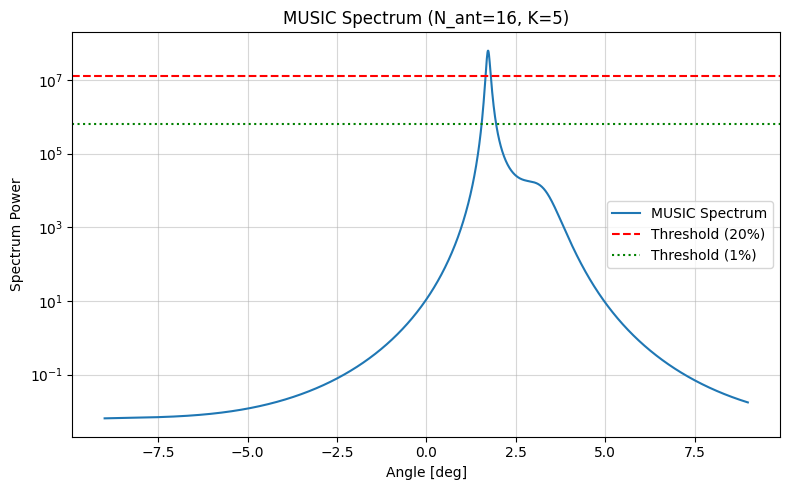

-> 診断用グラフを描画しました

角度 1.72 度 のマップからの検出:
  -> Index: (1, 118), Power: -8.7dB, Range: 281.54m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_14_for_0.png
失敗
使っているインデックス: 195 175
Cyclist True Position: [array([-25.5,  15. ])]
Cyclist True Range: 281.76275481333585
Cyclist True Angle: 3.2841346685664803
Vehicle True Position: [array([-27.5,   7.5])]
Vehicle True Range: 282.94434081635205
Vehicle True Angle: 1.703935376629593

【MUSIC法 デバッグ情報】


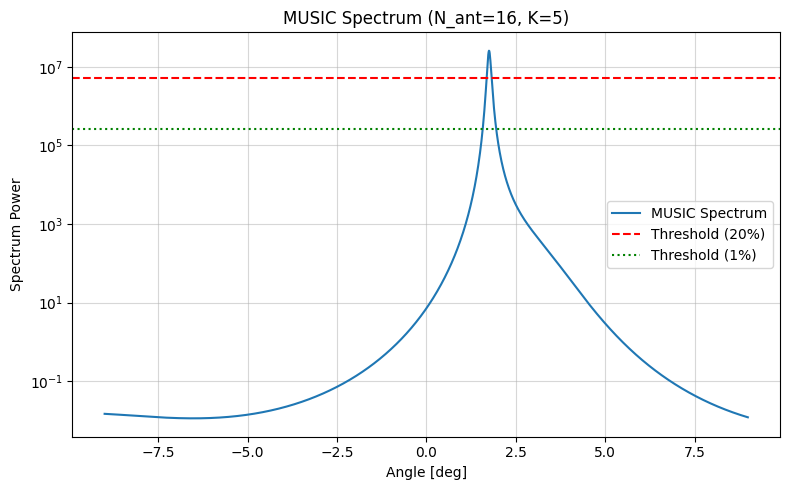

-> 診断用グラフを描画しました

角度 1.75 度 のマップからの検出:
  -> Index: (1, 117), Power: -10.2dB, Range: 281.16m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_15_for_0.png
失敗
使っているインデックス: 198 180
Cyclist True Position: [array([-25.2,  15. ])]
Cyclist True Range: 281.46942995643417
Cyclist True Angle: 3.29151021519117
Vehicle True Position: [array([-27. ,   7.5])]
Vehicle True Range: 282.453978552259
Vehicle True Angle: 1.7133592980179737

【MUSIC法 デバッグ情報】


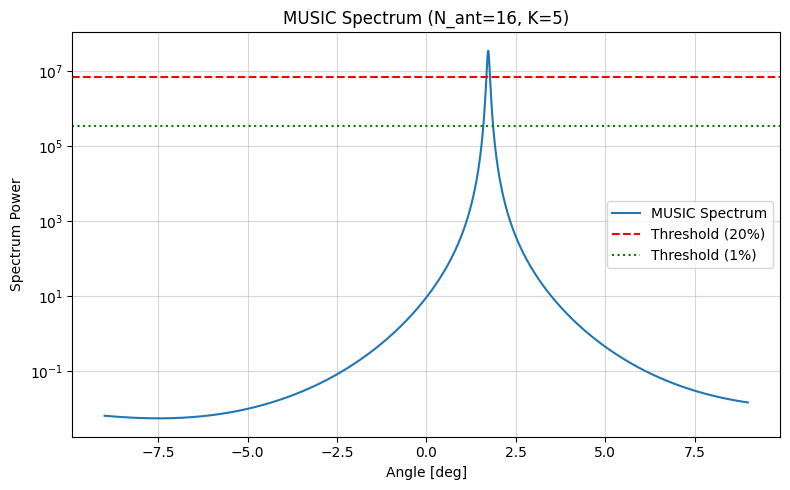

-> 診断用グラフを描画しました

角度 1.73 度 のマップからの検出:
  -> Index: (1, 115), Power: -9.7dB, Range: 280.39m, Vel: 10.79m/s
  -> Index: (1, 121), Power: -25.7dB, Range: 282.68m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_16_for_0.png
失敗
使っているインデックス: 201 185
Cyclist True Position: [array([-24.9,  15. ])]
Cyclist True Range: 281.1761191851114
Cyclist True Angle: 3.298901631333169
Vehicle True Position: [array([-26.5,   7.5])]
Vehicle True Range: 281.9636501395171
Vehicle True Angle: 1.7228170153777458

【MUSIC法 デバッグ情報】


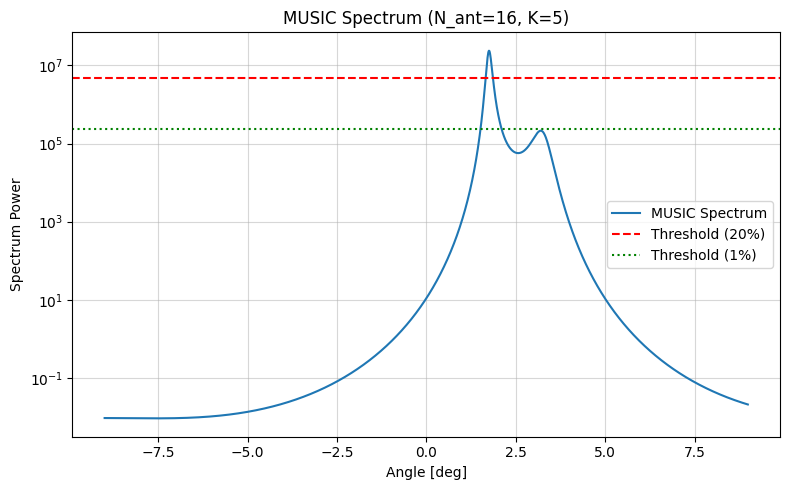

-> 診断用グラフを描画しました

角度 1.75 度 のマップからの検出:
  -> Index: (1, 114), Power: -9.9dB, Range: 280.01m, Vel: 10.79m/s
  -> Index: (1, 117), Power: -22.9dB, Range: 281.16m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_17_for_0.png
失敗
使っているインデックス: 204 190
Cyclist True Position: [array([-24.6,  15. ])]
Cyclist True Range: 280.8828225434941
Cyclist True Angle: 3.306308968019042
Vehicle True Position: [array([-26. ,   7.5])]
Vehicle True Range: 281.4733557550341
Vehicle True Angle: 1.732308710315448

【MUSIC法 デバッグ情報】


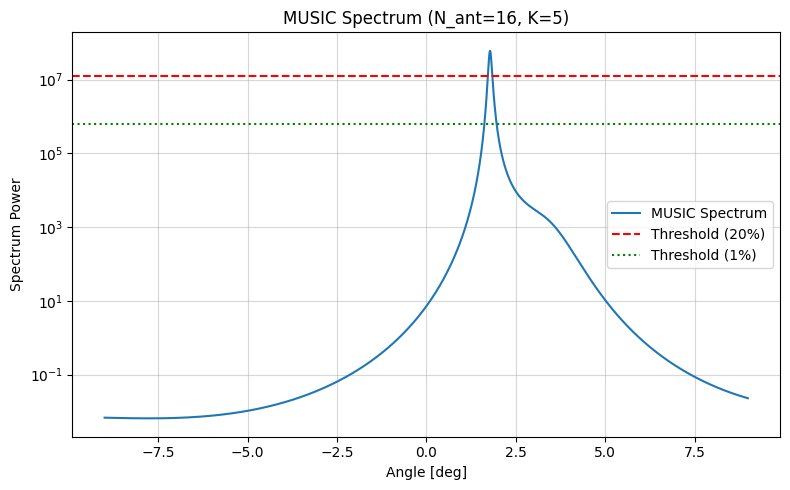

-> 診断用グラフを描画しました

角度 1.78 度 のマップからの検出:
  -> Index: (1, 113), Power: -9.5dB, Range: 279.63m, Vel: 10.79m/s
  -> Index: (1, 118), Power: -23.3dB, Range: 281.54m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_18_for_0.png
失敗
使っているインデックス: 207 195
Cyclist True Position: [array([-24.3,  15. ])]
Cyclist True Range: 280.5895400758909
Cyclist True Angle: 3.313732276493282
Vehicle True Position: [array([-25.5,   7.5])]
Vehicle True Range: 280.98309557694034
Vehicle True Angle: 1.7418345657373786

【MUSIC法 デバッグ情報】


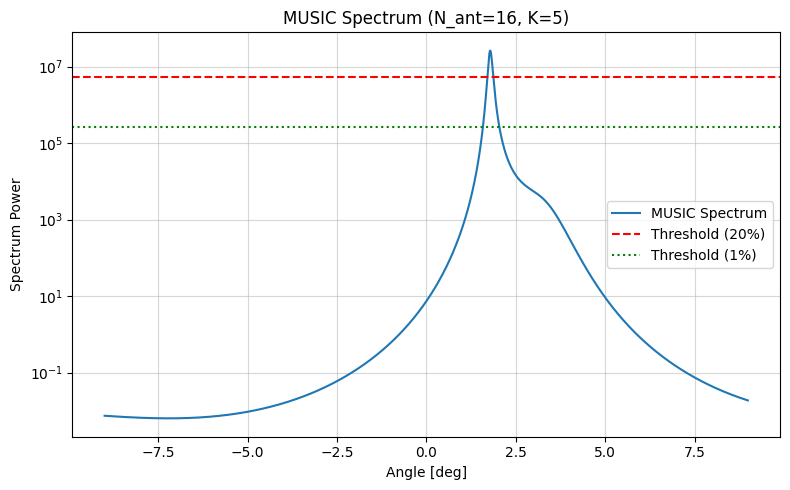

-> 診断用グラフを描画しました

角度 1.78 度 のマップからの検出:
  -> Index: (1, 111), Power: -12.7dB, Range: 278.87m, Vel: 10.79m/s
  -> Index: (1, 116), Power: -25.4dB, Range: 280.77m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_19_for_0.png
失敗
使っているインデックス: 210 200
Cyclist True Position: [array([-24.,  15.])]
Cyclist True Range: 280.296271826794
Cyclist True Angle: 3.3211716082194562
Vehicle True Position: [array([-25. ,   7.5])]
Vehicle True Range: 280.492869784599
Vehicle True Angle: 1.7513947658612101

【MUSIC法 デバッグ情報】


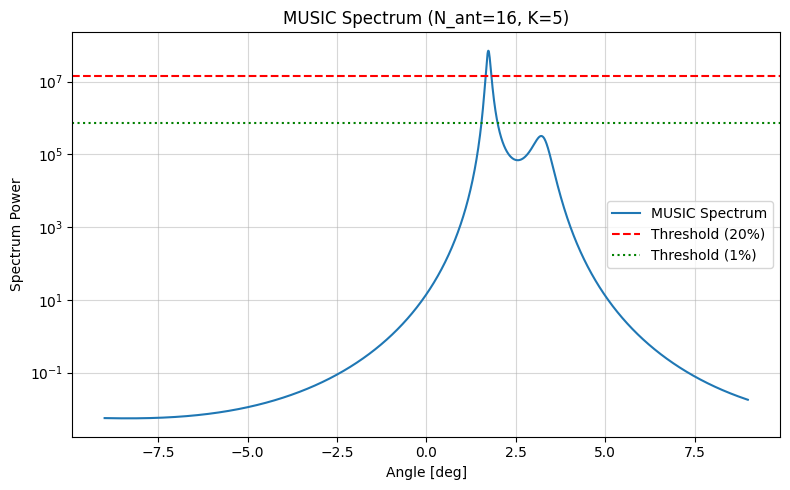

-> 診断用グラフを描画しました

角度 1.73 度 のマップからの検出:
  -> Index: (1, 110), Power: -11.0dB, Range: 278.48m, Vel: 10.79m/s
  -> Index: (1, 115), Power: -21.6dB, Range: 280.39m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_20_for_0.png
失敗
使っているインデックス: 213 205
Cyclist True Position: [array([-23.7,  15. ])]
Cyclist True Range: 280.0030178408797
Cyclist True Angle: 3.328627014881384
Vehicle True Position: [array([-24.5,   7.5])]
Vehicle True Range: 280.00267855861665
Vehicle True Angle: 1.7609894962277257

【MUSIC法 デバッグ情報】


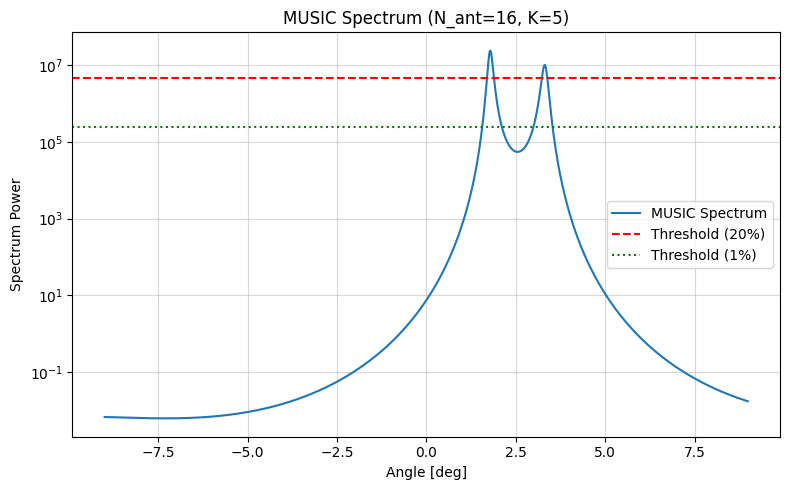

-> 診断用グラフを描画しました

角度 1.79 度 のマップからの検出:
  -> Index: (1, 109), Power: -11.1dB, Range: 278.10m, Vel: 10.79m/s
  -> Index: (1, 114), Power: -19.0dB, Range: 280.01m, Vel: 10.79m/s
角度 3.31 度 のマップからの検出:
  -> Index: (1, 109), Power: -12.6dB, Range: 278.10m, Vel: 10.79m/s
  -> Index: (1, 114), Power: -17.1dB, Range: 280.01m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_21_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_21_for_1.png
2
2
成功，強度差は -> 5.93159495589785
[np.float64(278.103223144845), np.float64(1.79), np.float64(-22.565981758824762), np.float64(7.45954263924347), np.float64(10.789412505668365), -11.140390747389521]
[np.float64(280.01065265887), np.float64(3.31), np.float64(-23.718412946784156), np.float64(14.911943369240483), np.float64(10.789412505668365), -17.07198570328737]
使っているインデックス: 216 210
Cyclist True Position: [array([-23.4,  15. ])]
Cyclist True Range: 279.7097781630095
Cyclist True Angle: 3.3360985483843066
Vehicle True Position: [array([-24. ,   7.5])]
Vehicle True Range

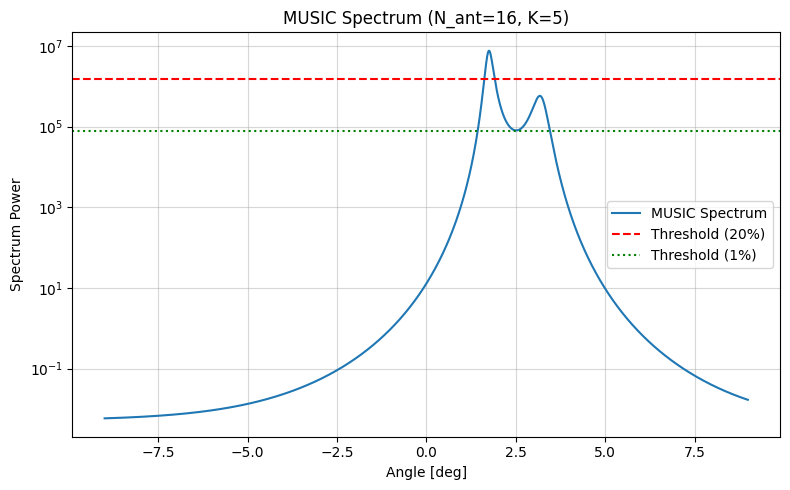

-> 診断用グラフを描画しました

角度 1.75 度 のマップからの検出:
  -> Index: (1, 108), Power: -11.5dB, Range: 277.72m, Vel: 10.79m/s
  -> Index: (1, 113), Power: -20.6dB, Range: 279.63m, Vel: 10.79m/s
角度 3.17 度 のマップからの検出:
  -> Index: (1, 108), Power: -12.6dB, Range: 277.72m, Vel: 10.79m/s
  -> Index: (1, 113), Power: -19.7dB, Range: 279.63m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_22_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_22_for_1.png
2
2
成功，強度差は -> 8.245771354735174
[np.float64(277.72173724204004), np.float64(1.75), np.float64(-22.197786660822487), np.float64(7.23347525978291), np.float64(10.789412505668365), -11.480814334517186]
[np.float64(279.62916675606505), np.float64(3.17), np.float64(-23.41320091209093), np.float64(14.19770904421378), np.float64(10.789412505668365), -19.72658568925236]
使っているインデックス: 219 215
Cyclist True Position: [array([-23.1,  15. ])]
Cyclist True Range: 279.41655283823115
Cyclist True Angle: 3.3435862608560645
Vehicle True Position: [array([-23.5,   7.5])]
Vehicle True 

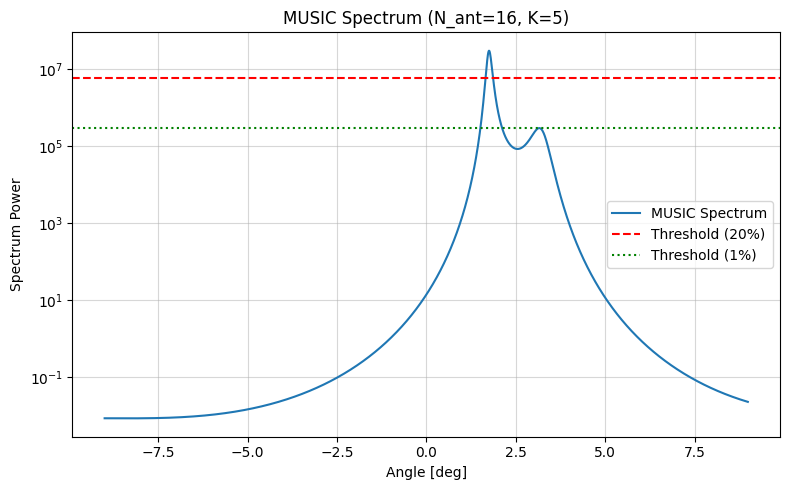

-> 診断用グラフを描画しました

角度 1.75 度 のマップからの検出:
  -> Index: (1, 106), Power: -11.7dB, Range: 276.96m, Vel: 10.79m/s
  -> Index: (1, 113), Power: -23.6dB, Range: 279.63m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_23_for_0.png
失敗
使っているインデックス: 222 220
Cyclist True Position: [array([-22.8,  15. ])]
Cyclist True Range: 279.1233419117792
Cyclist True Angle: 3.3510902046482935
Vehicle True Position: [array([-23. ,   7.5])]
Vehicle True Range: 278.5323141037679
Vehicle True Angle: 1.7899827442879892

【MUSIC法 デバッグ情報】


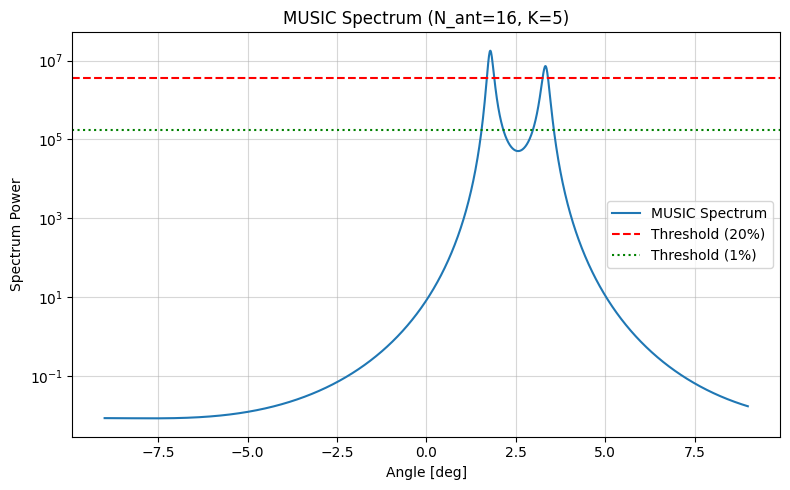

-> 診断用グラフを描画しました

角度 1.79 度 のマップからの検出:
  -> Index: (1, 105), Power: -11.3dB, Range: 276.58m, Vel: 10.79m/s
  -> Index: (1, 112), Power: -16.8dB, Range: 279.25m, Vel: 10.79m/s
角度 3.33 度 のマップからの検出:
  -> Index: (1, 105), Power: -12.6dB, Range: 276.58m, Vel: 10.79m/s
  -> Index: (1, 112), Power: -14.6dB, Range: 279.25m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_24_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_24_for_1.png
2
2
成功，強度差は -> 3.2739579456049572
[np.float64(276.577279533625), np.float64(1.79), np.float64(-21.022368408857915), np.float64(7.315358505741585), np.float64(10.789412505668365), -11.318666379289802]
[np.float64(279.24768085326), np.float64(3.33), np.float64(-22.937519534319108), np.float64(14.914703285573452), np.float64(10.789412505668365), -14.592624324894759]
使っているインデックス: 225 225
Cyclist True Position: [array([-22.5,  15. ])]
Cyclist True Range: 278.8301454290766
Cyclist True Angle: 3.358610432337613
Vehicle True Position: [array([-22.5,   7.5])]
Vehicle True Ra

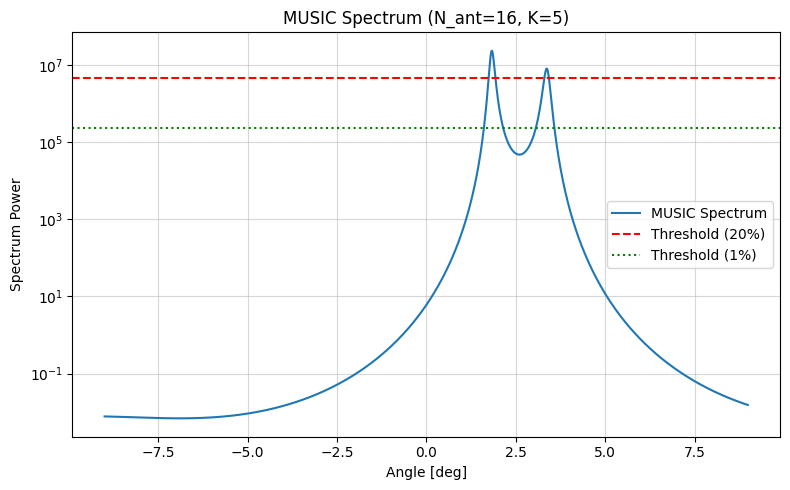

-> 診断用グラフを描画しました

角度 1.83 度 のマップからの検出:
  -> Index: (1, 104), Power: -10.2dB, Range: 276.20m, Vel: 10.79m/s
  -> Index: (1, 111), Power: -17.8dB, Range: 278.87m, Vel: 10.79m/s
角度 3.37 度 のマップからの検出:
  -> Index: (1, 104), Power: -11.7dB, Range: 276.20m, Vel: 10.79m/s
  -> Index: (1, 111), Power: -15.4dB, Range: 278.87m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_25_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_25_for_1.png
2
2
成功，強度差は -> 5.224455161903409
[np.float64(276.19579363082005), np.float64(1.83), np.float64(-20.61870789190715), np.float64(7.468242151220419), np.float64(10.789412505668365), -10.154997354990625]
[np.float64(278.866194950455), np.float64(3.37), np.float64(-22.529787548846002), np.float64(15.058578080825129), np.float64(10.789412505668365), -15.379452516894034]
使っているインデックス: 228 230
Cyclist True Position: [array([-22.2,  15. ])]
Cyclist True Range: 278.53696343573506
Cyclist True Angle: 3.366146996726834
Vehicle True Position: [array([-22. ,   7.5])]
Vehicle True 

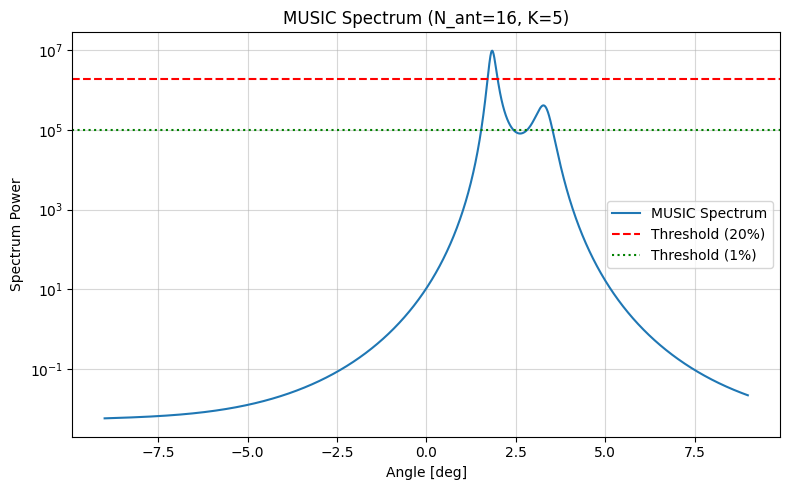

-> 診断用グラフを描画しました

角度 1.84 度 のマップからの検出:
  -> Index: (1, 102), Power: -12.9dB, Range: 275.43m, Vel: 10.79m/s
  -> Index: (1, 111), Power: -21.6dB, Range: 278.87m, Vel: 10.79m/s
  -> Index: (1, 107), Power: -25.3dB, Range: 277.34m, Vel: 10.79m/s
角度 3.27 度 のマップからの検出:
  -> Index: (1, 102), Power: -14.4dB, Range: 275.43m, Vel: 10.79m/s
  -> Index: (1, 111), Power: -20.8dB, Range: 278.87m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_26_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_26_for_1.png
2
2
成功，強度差は -> 7.981520724443852
[np.float64(275.43282182521), np.float64(1.84), np.float64(-19.842377336037714), np.float64(7.442695066232918), np.float64(10.789412505668365), -12.854866158373115]
[np.float64(278.866194950455), np.float64(3.27), np.float64(-22.58707053640859), np.float64(14.582873760982892), np.float64(10.789412505668365), -20.836386882816967]
使っているインデックス: 231 235
Cyclist True Position: [array([-21.9,  15. ])]
Cyclist True Range: 278.2437959775563
Cyclist True Angle: 3.373699950846

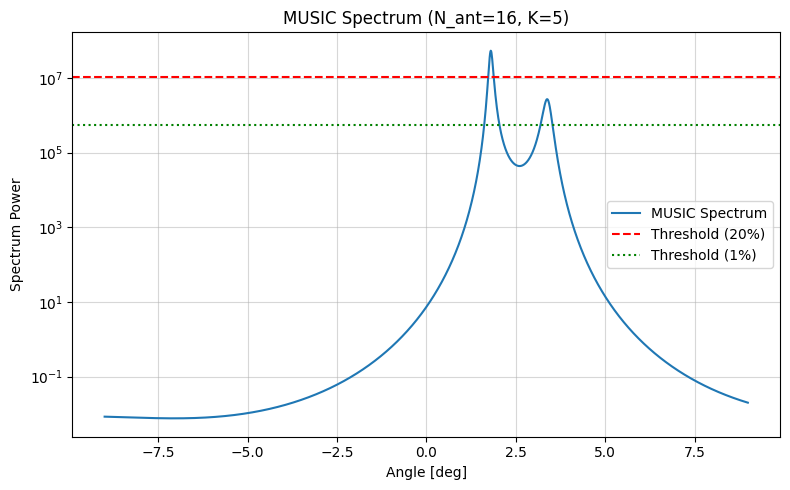

-> 診断用グラフを描画しました

角度 1.80 度 のマップからの検出:
  -> Index: (1, 101), Power: -10.7dB, Range: 275.05m, Vel: 10.79m/s
  -> Index: (1, 110), Power: -20.5dB, Range: 278.48m, Vel: 10.79m/s
角度 3.38 度 のマップからの検出:
  -> Index: (1, 101), Power: -12.1dB, Range: 275.05m, Vel: 10.79m/s
  -> Index: (1, 110), Power: -18.3dB, Range: 278.48m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_27_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_27_for_1.png
2
2
成功，強度差は -> 7.522769857595367
[np.float64(275.05133592240503), np.float64(1.8), np.float64(-19.474081751809308), np.float64(7.218181074750095), np.float64(10.789412505668365), -10.729235494129483]
[np.float64(278.48470904765003), np.float64(3.38), np.float64(-22.139318296213844), np.float64(15.05941031879307), np.float64(10.789412505668365), -18.25200535172485]
使っているインデックス: 234 240
Cyclist True Position: [array([-21.6,  15. ])]
Cyclist True Range: 277.9506431005332
Cyclist True Angle: 3.381269347954454
Vehicle True Position: [array([-21. ,   7.5])]
Vehicle True R

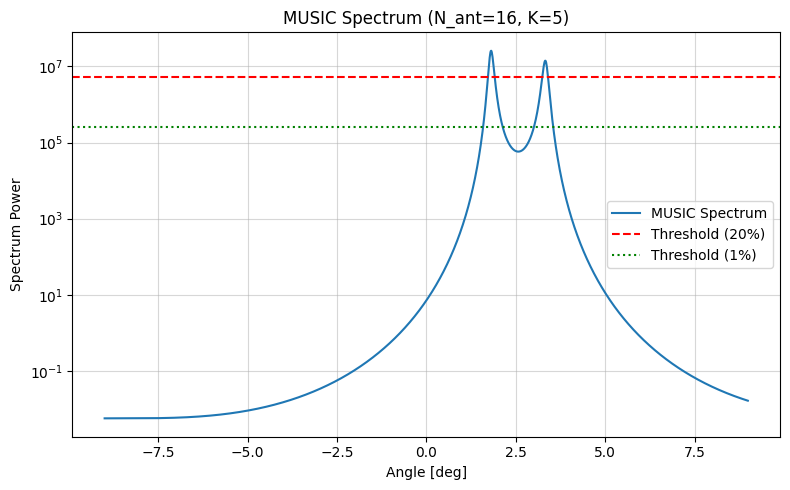

-> 診断用グラフを描画しました

角度 1.81 度 のマップからの検出:
  -> Index: (1, 100), Power: -10.6dB, Range: 274.67m, Vel: 10.79m/s
  -> Index: (1, 109), Power: -17.4dB, Range: 278.10m, Vel: 10.79m/s
  -> Index: (1, 105), Power: -24.1dB, Range: 276.58m, Vel: 10.79m/s
角度 3.32 度 のマップからの検出:
  -> Index: (1, 100), Power: -11.9dB, Range: 274.67m, Vel: 10.79m/s
  -> Index: (1, 109), Power: -15.6dB, Range: 278.10m, Vel: 10.79m/s
  -> Index: (1, 105), Power: -26.4dB, Range: 276.58m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_28_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_28_for_1.png
2
2
成功，強度差は -> 4.976924548790922
[np.float64(274.66985001960006), np.float64(1.81), np.float64(-19.08367283156906), np.float64(7.229021488411117), np.float64(10.789412505668365), -10.587075429624983]
[np.float64(278.103223144845), np.float64(3.32), np.float64(-21.78902794885522), np.float64(14.728076786879285), np.float64(10.789412505668365), -15.563999978415906]
使っているインデックス: 237 245
Cyclist True Position: [array([-21.3,  15. ])]
Cy

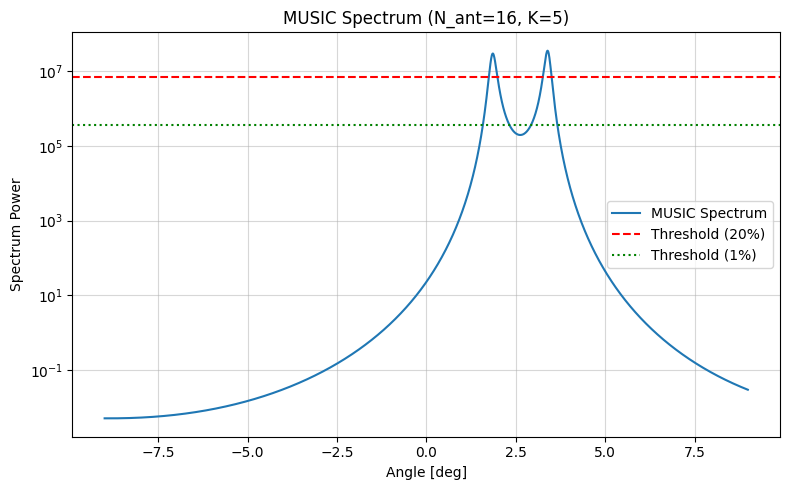

-> 診断用グラフを描画しました

角度 1.86 度 のマップからの検出:
  -> Index: (1, 99), Power: -13.1dB, Range: 274.29m, Vel: 10.79m/s
  -> Index: (0, 108), Power: -17.6dB, Range: 277.72m, Vel: 0.00m/s
角度 3.39 度 のマップからの検出:
  -> Index: (1, 99), Power: -13.9dB, Range: 274.29m, Vel: 10.79m/s
  -> Index: (1, 108), Power: -16.0dB, Range: 277.72m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_29_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_29_for_1.png
2
2
成功，強度差は -> 2.8744335783897554
[np.float64(274.28836411679504), np.float64(1.86), np.float64(-18.67556459532426), np.float64(7.427301847645573), np.float64(10.789412505668365), -13.129392788186781]
[np.float64(277.72173724204004), np.float64(3.39), np.float64(-21.364119357290917), np.float64(15.013301291732375), np.float64(10.789412505668365), -16.003826366576536]
使っているインデックス: 240 250
Cyclist True Position: [array([-21.,  15.])]
Cyclist True Range: 277.3643812748854
Cyclist True Angle: 3.396457685323698
Vehicle True Position: [array([-20. ,   7.5])]
Vehicle True Ran

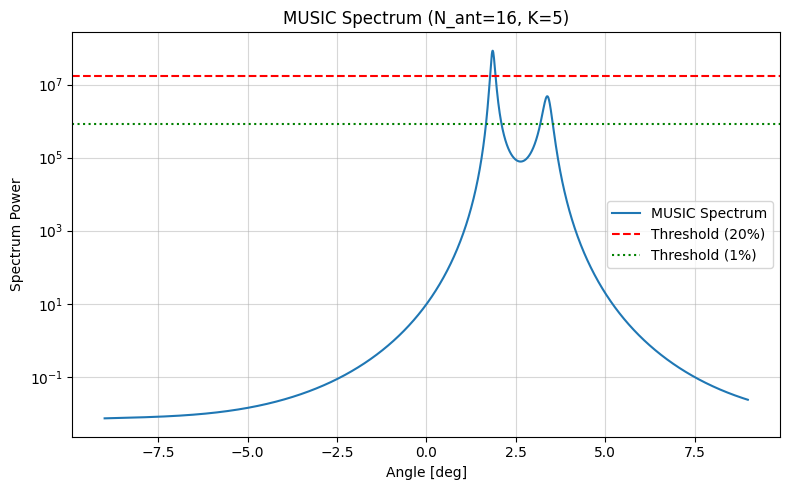

-> 診断用グラフを描画しました

角度 1.85 度 のマップからの検出:
  -> Index: (1, 97), Power: -10.5dB, Range: 273.53m, Vel: 10.79m/s
  -> Index: (1, 107), Power: -19.1dB, Range: 277.34m, Vel: 10.79m/s
角度 3.38 度 のマップからの検出:
  -> Index: (1, 97), Power: -11.7dB, Range: 273.53m, Vel: 10.79m/s
  -> Index: (1, 107), Power: -19.1dB, Range: 277.34m, Vel: 10.79m/s
Saved: ./montecarlo\rd_maps\rd_map_30_for_0.png
Saved: ./montecarlo\rd_maps\rd_map_30_for_1.png
2
2
成功，強度差は -> 8.586735172047256
[np.float64(273.52539231118504), np.float64(1.85), np.float64(-17.907953884074914), np.float64(7.30747882812652), np.float64(10.789412505668365), -10.469690176279208]
[np.float64(277.340251339235), np.float64(3.38), np.float64(-20.985131116014657), np.float64(14.91919997427621), np.float64(10.789412505668365), -19.056425348326464]

Data generation complete.
Saved './montecarlo\measurements_0.csv'.
Saved true positions to './montecarlo\true_information_0.csv'.


In [725]:
def montecarlo_simulation():
    np.random.seed(42)  # 再現性のためのシード設定
    num_simulations = 1
    for i in range(num_simulations):
        print(f"\n--- Simulation Run {i+1}/{num_simulations} ---")
        main_simulation(i)

montecarlo_simulation()

In [721]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_range_power_with_miss_counts(file_path):
    # 1. CSVファイルを読み込む
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"エラー: ファイル '{file_path}' が見つかりませんでした。")
        return

    # 必要な列の確認
    required_cols = ['Time', 'Range', 'Power']
    if not all(col in df.columns for col in required_cols):
        print(f"エラー: 必要な列 {required_cols} がCSVに含まれていません。")
        return

    # 2. データの整理と欠損の特定
    # Timeをインデックスに設定
    df = df.sort_values('Time')
    df = df.set_index('Time')

    # 時間ステップ（間隔）を自動判定（最頻値を使用）
    # データが1行しかない場合などは1と仮定
    if len(df) > 1:
        time_diffs = df.index.to_series().diff().dropna()
        dt = time_diffs.mode()[0]  # 最も頻出する間隔をステップとする
    else:
        dt = 1 

    # 完全な時間の並びを作成（最初から最後までの等間隔な時刻）
    full_time_idx = range(int(df.index.min()), int(df.index.max()) + int(dt), int(dt))
    
    # データを再構築（欠損していた時刻にはNaNが入る）
    df_reindexed = df.reindex(full_time_idx)

    # 検出漏れの判定（RangeまたはPowerがNaNの行）
    is_missed = df_reindexed['Range'].isna() | df_reindexed['Power'].isna()
    miss_count = is_missed.sum()

    print(f"検出漏れ回数: {miss_count} 回")

    # 3. プロット用のデータ準備
    # 検出漏れ箇所をプロットするために補間（Interpolate）を行う
    # Time（インデックス）に基づいて線形補間
    df_interp = df_reindexed.interpolate(method='index')

    # プロット開始
    plt.figure(figsize=(10, 6))

    # (A) 検出成功データのプロット（青い線と丸）
    # 欠損箇所で線が切れるように、補間していない元のdf_reindexedを使用
    plt.plot(df_reindexed['Range'], df_reindexed['Power'], 
             'o-', color='blue', alpha=0.7, label='Detected Signal')

    # (B) 検出漏れ箇所のプロット（赤い×）
    # 補間データのうち、検出漏れだった箇所だけを抽出してプロット
    if miss_count > 0:
        missed_data = df_interp[is_missed]
        plt.scatter(missed_data['Range'], missed_data['Power'], 
                    color='red', marker='x', s=100, zorder=5, 
                    label=f'Missed Detection ({miss_count} times)')
        
        # オプション: 検出漏れ箇所を赤い点線で結ぶ場合
        # plt.plot(df_interp['Range'], df_interp['Power'], 'r:', alpha=0.4)

    # 4. グラフの装飾
    plt.title(f'Range vs Power (Total Misses: {miss_count})')
    plt.xlabel('Distance (Range) [m]')
    plt.ylabel('Intensity (Power) [dB]')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.ylim(-28, -7)
    # 表示
    plt.show()

if __name__ == "__main__":
    plot_range_power_with_miss_counts('montecarlo/measurements_0.csv')

ValueError: cannot reindex on an axis with duplicate labels